In [1]:
#IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import font_manager as fm
from matplotlib.ticker import FuncFormatter
import numpy as np
import glob
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from datetime import datetime
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
# --- função utilitária: previsão por média dos últimos 3 meses do ANO CORRENTE ---
def previsao_media3m(df_base, ano, implementadora=None):
    """
    Método: média dos últimos 3 meses *do próprio ano* × meses restantes + acumulado do ano.
    df_base: DataFrame com colunas 'Ano','Mes','Qtde' e (opcional) 'Implementadora'
    ano: int do ano alvo (ex.: ano atual)
    implementadora: None para total geral ou uma string (ex.: 'FACCHINI')
    """
    df_ano = df_base[df_base['Ano'] == ano].copy()
    if implementadora is not None and 'Implementadora' in df_ano.columns:
        df_ano = df_ano[df_ano['Implementadora'].str.upper().str.strip() == implementadora.upper().strip()]

    if df_ano.empty:
        return 0.0  # sem dados no ano → previsão 0

    # garante tipos
    df_ano['Mes'] = pd.to_numeric(df_ano['Mes'], errors='coerce').astype('Int64')

    # agrega por mês dentro do ano
    mensal = (
        df_ano.dropna(subset=['Mes'])
              .groupby('Mes', as_index=True)['Qtde']
              .sum()
              .sort_index()
    )

    if mensal.empty:
        return 0.0

    # acumulado do ano (YTD)
    ytd = mensal.sum()

    # último mês com dado e meses restantes no ano
    ultimo_mes = int(mensal.index.max())
    meses_restantes = max(0, 12 - ultimo_mes)

    # média dos últimos 3 meses com dados no ano (se tiver menos, usa o que houver)
    ultimos3_idx = mensal.index[-3:]
    media_3m = mensal.loc[ultimos3_idx].mean()

    # previsão = YTD + média_3m * meses_restantes
    return float(ytd + media_3m * meses_restantes)

In [3]:
#DADOS PRODUÇÃO DE CAMINHÃO

df_anfavea = pd.read_excel('arquivos/SeriesTemporais_Autoveiculos (1).xlsm', header= None)
df_anfavea = df_anfavea.drop(index= [0, 1, 2, 3])
df_anfavea.columns = df_anfavea.iloc[0]
df_anfavea = df_anfavea.drop(index= 4)
df_anfavea.reset_index(drop = True, inplace= True)
df_anfavea = df_anfavea.iloc[:, [0, 16, 17, 18, 19, 20]]
df_anfavea = df_anfavea.rename(columns={df_anfavea.columns[0]: 'Data'})
df_anfavea['Data'] = pd.to_datetime(df_anfavea['Data'])
df_anfavea['Ano'] = df_anfavea['Data'].dt.year
df_anfavea_ano_filtrado = df_anfavea[df_anfavea['Ano']>= 2013]

In [7]:
#DADOS EMPLACAMENTO

# df_emplacamento = pd.read_excel('arquivos/Emplacamento Detalhado.xlsx', header= None)
# df_emplacamento.columns = df_emplacamento.iloc[2]
# df_emplacamento = df_emplacamento.drop(index= [0, 1, 2])
# df_emplacamento.reset_index(drop = True, inplace= True)
# df_emplacamento['Data'] = pd.to_datetime(df_emplacamento['Data'])
# df_emplacamento['Ano'] = df_emplacamento['Data'].dt.year
# df_emplacamento_filtrado = df_emplacamento[df_emplacamento['Ano']>= 2013]

arquivos_emplacamento = glob.glob('arquivos/Emplacamento/*.xlsx')

dfs = []

for arquivo in arquivos_emplacamento:
    df = pd.read_excel(arquivo, skiprows = 3, header= None)
    df = df.drop(columns=[11], axis= 1, errors="ignore")
    dfs.append(df)

df_emplacamento = pd.concat(dfs, ignore_index= True)
df_emplacamento.columns = ['Tipo', 'UF', 'Cidade', 'Qtde', 'Implementadora', 'Mix Produto' , 'Modelo', 'Cliente', 'Representante', 'Faturado', 'Data']

df_emplacamento['Data'] = pd.to_datetime(df_emplacamento['Data'])
df_emplacamento['Mes'] = pd.to_datetime(df_emplacamento['Data'], errors='coerce').dt.month
df_emplacamento['Ano'] = df_emplacamento['Data'].dt.year

df_emplacamento_teste = df_emplacamento[df_emplacamento['Ano'] == 2025 & df_emplacamento['Mes'] == 8]
df_emplacamento_teste.head(10)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [4]:
df_anfavea.head(10)

4,Data,Emplacamento Total,Emplacamento Nacionais,Emplacamento Importados,Produção,Exportação,Ano
0,1957-01-01,1037,1037,0,981,0,1957
1,1957-02-01,1262,1262,0,1103,0,1957
2,1957-03-01,1706,1706,0,1290,0,1957
3,1957-04-01,1525,1525,0,1266,0,1957
4,1957-05-01,1698,1698,0,1439,0,1957
5,1957-06-01,1659,1659,0,1431,0,1957
6,1957-07-01,1589,1589,0,1541,0,1957
7,1957-08-01,1810,1810,0,1483,0,1957
8,1957-09-01,1314,1314,0,1477,0,1957
9,1957-10-01,1176,1176,0,1501,0,1957


In [29]:
df = df_emplacamento.copy()
df_sc = df[df['Tipo'] == 'SOBRE CHASSI']
df_sr = df[df['Tipo'] == 'SEMIRREBOQUE']
ano_atual = datetime.now().year

def prepara_emplacamento(df, ano_atual= datetime.now().year):
    df['Qtde'] = pd.to_numeric(df['Qtde'], errors= 'coerce').fillna(0)
    df['Ano'] = pd.to_numeric(df['Ano'], errors='coerce')

    totais = df.groupby("Ano")['Qtde'].sum()

    totais_facchini =(
        df[df['Implementadora'].str.upper().str.strip() == 'FACCHINI']
        .groupby("Ano")['Qtde'].sum()
        .reindex(totais.index, fill_value= 0)
    )

    tabela = pd.DataFrame({
        "Total_Geral": totais,
        "Total_Facchini": totais_facchini
    }).sort_index()
    #Adiciona previsão no dataframe

    prev_geral = previsao_media3m(df, ano_atual, implementadora=None)

    prev_facchini = previsao_media3m(df, ano_atual, implementadora= 'FACCHINI')

    # adiciona as colunas de previsão na sua 'tabela' apenas para o ano atual
    if ano_atual in tabela.index:
        tabela.loc[ano_atual, 'Previsto_Total_Geral']= prev_geral
        tabela.loc[ano_atual, 'Previsto_Total_Facchini'] = prev_facchini
    else:
        # se o ano ainda não existe na tabela, cria a linha
        tabela.loc[ano_atual, 'Total_Geral'] = 0
        tabela.loc[ano_atual, 'Total_Facchini'] = 0
        tabela.loc[ano_atual, 'Previsto_Total_Geral'] = prev_geral
        tabela.loc[ano_atual, 'Previsto_Total_Facchini'] = prev_facchini

    if ano_atual in tabela.index:
        if "Previsto_Total_Geral" in tabela.columns:
            tabela.loc[ano_atual, "Total_Geral"] = tabela.loc[ano_atual, "Previsto_Total_Geral"]
        if "Previsto_Total_Facchini" in tabela.columns:
            tabela.loc[ano_atual, "Total_Facchini"] = tabela.loc[ano_atual, "Previsto_Total_Facchini"]

    tabela = tabela.sort_index()  
    
    return tabela

tabela = prepara_emplacamento(df, ano_atual)
tabela_sc = prepara_emplacamento(df_sc, ano_atual)
tabela_sr = prepara_emplacamento(df_sr, ano_atual)


C:\Users\gsribeiro\AppData\Local\Temp\ipykernel_10568\2941331066.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '149198.6666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabela.loc[ano_atual, "Total_Geral"] = tabela.loc[ano_atual, "Previsto_Total_Geral"]
C:\Users\gsribeiro\AppData\Local\Temp\ipykernel_10568\2941331066.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '27904.333333333332' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabela.loc[ano_atual, "Total_Facchini"] = tabela.loc[ano_atual, "Previsto_Total_Facchini"]
C:\Users\gsribeiro\AppData\Local\Temp\ipykernel_10568\2941331066.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

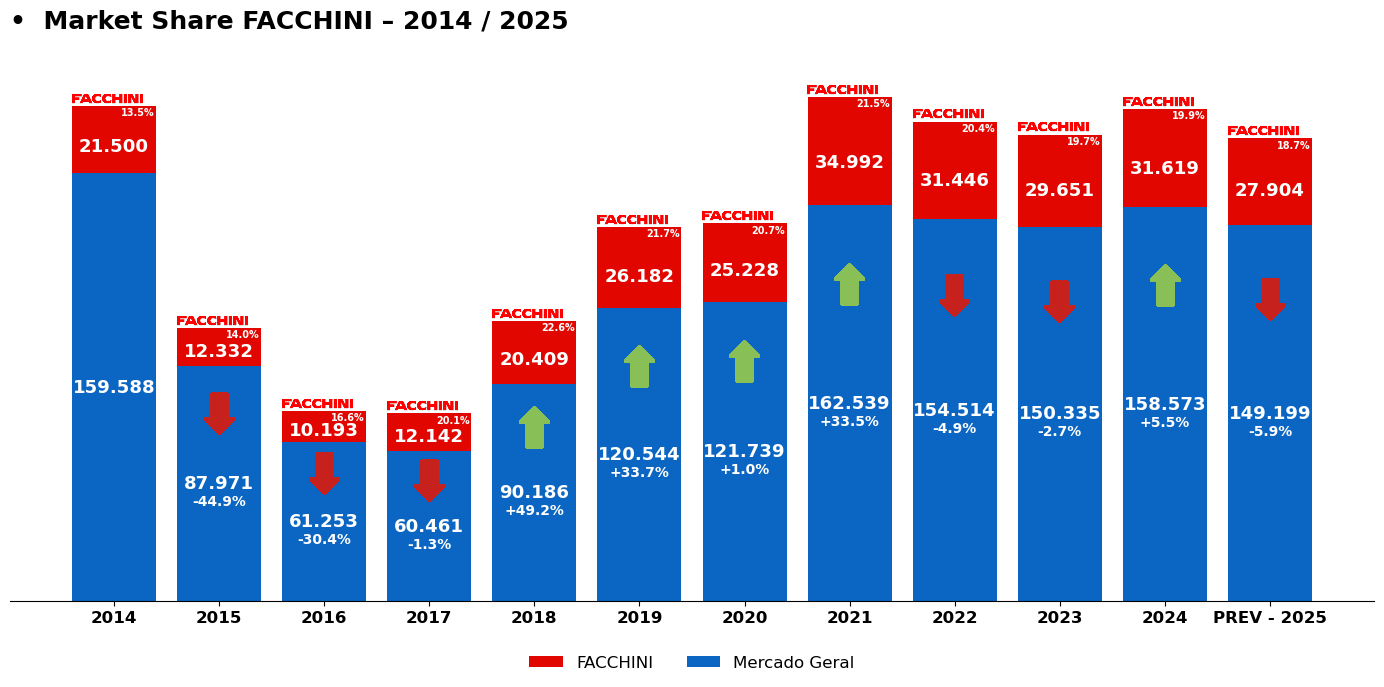

In [30]:
# ======== DADOS (a partir da sua tabela) ========
totais = tabela["Total_Geral"].astype(float).copy()
fac    = tabela["Total_Facchini"].astype(float).reindex(totais.index, fill_value=0)
outros = (totais - fac).clip(lower=0)

LOGO_PATH = "arquivos/logoprincipal.png"   # troque se estiver em outro caminho
LOGO_ZOOM = 0.22               # ajuste o tamanho da logo aqui

# arquivos das setas 
ARROW_UP_PATH   = "arquivos/seta-verde-para-cima.png"
ARROW_DOWN_PATH = "arquivos/seta-vermelha-para-baixo.png"
FRACT_DENTRO_AZUL = 0.8   # altura-alvo dentro do azul (0=base azul, 1=topo azul)
ARROW_ZOOM   = 0.06        # tamanho da seta
ARROW_SHIFT  = (0, 0)      # deslocamento extra da seta em points (x,y)
PCT_SHIFT    = (0, -50)     # deslocamento do texto % em points RELATIVO à seta
PCT_ALIGN    = ("center", "top")  # (ha, va) do texto %

# ---- posicionamento do % (variação YoY) ----
PCT_REF   = "azul"      # "azul" (alinha ao valor do bloco azul) ou "seta" (comporta-se como antes)
PCT_POS   = "above"     # "below" = abaixo da referência | "above" = acima da referência
PCT_DIST  = 18          # distância (em points) entre o % e a referência escol

_img_up = plt.imread(ARROW_UP_PATH)
_img_down = plt.imread(ARROW_DOWN_PATH)
logo_img = plt.imread(LOGO_PATH)

anos = totais.index.to_list()

# métricas
share_fac = np.where(totais.values>0, (fac.values / totais.values) * 100, np.nan)
var_tot   = np.r_[np.nan, np.diff(totais.values) / totais.values[:-1] * 100]  # % vs ano anterior

# ======== ESTILO ========
plt.rcParams.update({
    "font.size": 12,
    "axes.titleweight": "bold",
    "axes.titlesize": 18,
})

azul   = "#0B66C3"
vermelho = "#E10600"
branco = "#FFFFFF"
preto  = "#000000"
verde  = "#1FA650"

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor("white")

# ======== BARRAS ========
bars_azul = ax.bar(anos, outros, color=azul, edgecolor="none")
bars_verm = ax.bar(anos, fac, bottom=outros, color=vermelho, edgecolor="none")

# ======== RÓTULOS (como na imagem 2) ========

for i, ano in enumerate(anos):
    y_outros = outros.iloc[i]
    y_fac    = fac.iloc[i]
    y_total  = totai = totais.iloc[i]
    topo     = y_outros + y_fac
    
    # 2) Dentro do azul: valor do mercado (azul) em branco, centralizado
    if y_outros > 0:
        ax.text(ano, y_outros/2, f"{int(round(y_total,0)):,}".replace(",","."), 
                ha="center", va="center", fontsize=13, fontweight="bold", color=branco)

    # 3) Faixa vermelha: título FACCHINI + valor em branco
    if y_fac > 0:
        # valor FACCHINI no meio da faixa
        ax.text(ano, y_outros + y_fac*0.4, f"{int(round(y_fac,0)):,}".replace(",","."), 
                ha="center", va="center", fontsize=13, fontweight="bold", color=branco)
        # 4) % de share acima da palavra (ou logo abaixo do topo vermelho)
        ax.annotate(
            f"{share_fac[i]:.1f}%",
            xy=(ano, topo),
            xytext=(5, -1),              # -8 p/ esquerda, -4 p/ baixo
            textcoords="offset points",
            ha="left", va="top",
            fontsize=7, fontweight="bold", color=branco,
            clip_on=True
        )
        # === LOGO no topo da barra ===
        ab = AnnotationBbox(
            OffsetImage(logo_img, zoom=LOGO_ZOOM),
            (ano, topo),                   # âncora: topo da barra
            frameon=False,
            boxcoords="offset points",     # deslocar em pontos de tela
            xybox=(0, 1),                  # 6 pts acima do topo
            box_alignment=(0.6, 0.0)       # alinhar a base da logo no topo da barra
        )
        ax.add_artist(ab)

# ======== Variação YoY com setas (como na imagem 2) ========
for i, ano in enumerate(anos):
    if i == 0 or np.isnan(var_tot[i]): 
        continue

    y_outros = outros.iloc[i]
    y_total  = totais.iloc[i]

    # ancora "dentro" do bloco azul
    if y_outros > 0:
        y_anchor = FRACT_DENTRO_AZUL * y_outros
    else:
        y_anchor = FRACT_DENTRO_AZUL * y_total

    up        = var_tot[i] >= 0
    seta_img  = _img_up if up else _img_down
    cor_texto = verde if up else vermelho

        # --- seta (PNG) ---
    ab = AnnotationBbox(
        OffsetImage(seta_img, zoom=ARROW_ZOOM),
        (ano, y_anchor),
        frameon=False,
        xybox=ARROW_SHIFT,               # ajuste fino da seta
        boxcoords="offset points",
        box_alignment=(0.5, 0.5),
        clip_on=True
    )
    ax.add_artist(ab)

    # --- texto da % (ALINHADO ao valor do bloco azul ou à seta, conforme PCT_REF) ---
    # referência vertical para alinhar o %:
    if PCT_REF == "azul":
        # usa o mesmo y do rótulo do mercado (bloco azul)
        y_ref_pct = (y_outros/2) if y_outros > 0 else (0.5 * y_total)
    else:
        # mantém o comportamento antigo: referencia na seta
        y_ref_pct = y_anchor

    # decide acima/abaixo e a distância
    if PCT_POS.lower() == "below":
        va_pct = "top"       # âncora no topo do texto => texto aparece para baixo
        dy     = +PCT_DIST
    else:
        va_pct = "bottom"    # âncora na base do texto => texto aparece para cima
        dy     = -PCT_DIST

    ax.annotate(
        f"{var_tot[i]:+,.1f}%".replace(",", "."),
        xy=(ano, y_ref_pct),             # âncora em x=centro da barra e y=referência escolhida
        xytext=(0, dy),                  # distância controlada em points
        textcoords="offset points",
        ha="center", va=va_pct,          # centralizado no x da barra; acima/abaixo conforme PCT_POS
        fontsize=10, fontweight="bold",
        color= branco,
        clip_on=True
    )


# ======== TÍTULOS/LEGENDAS ========
ax.set_title("•  Market Share FACCHINI – 2014 / 2025", loc="left")
# legenda simples com caixas coloridas
leg_azul = Patch(facecolor=azul, label="Mercado Geral")
leg_verm = Patch(facecolor=vermelho, label="FACCHINI")
ax.legend(handles=[leg_verm, leg_azul], loc="lower center", frameon=False, bbox_to_anchor=(0.5, -0.15), ncol = 2)

# ======== EIXOS ========
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks(anos)
ax.set_xticklabels([f"PREV - 2025" if a == ano_atual else str(a) for a in anos], fontproperties=fm.FontProperties(weight='bold'))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_yticks([])  # sem grade/valores no eixo Y para ficar igual ao design
ax.margins(x=0.05, y=0.12)

plt.tight_layout()
plt.show()

In [31]:
### AGRUPA PRODUÇÃO DE CAMINHÕES POR ANO
valores_prod_ano = df_anfavea_ano_filtrado.groupby('Ano')['Produção'].sum()
variacao_prod_ano = valores_prod_ano.pct_change() * 100

C:\Users\gsribeiro\AppData\Local\Temp\ipykernel_10568\30708029.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  variacao_prod_ano = valores_prod_ano.pct_change() * 100


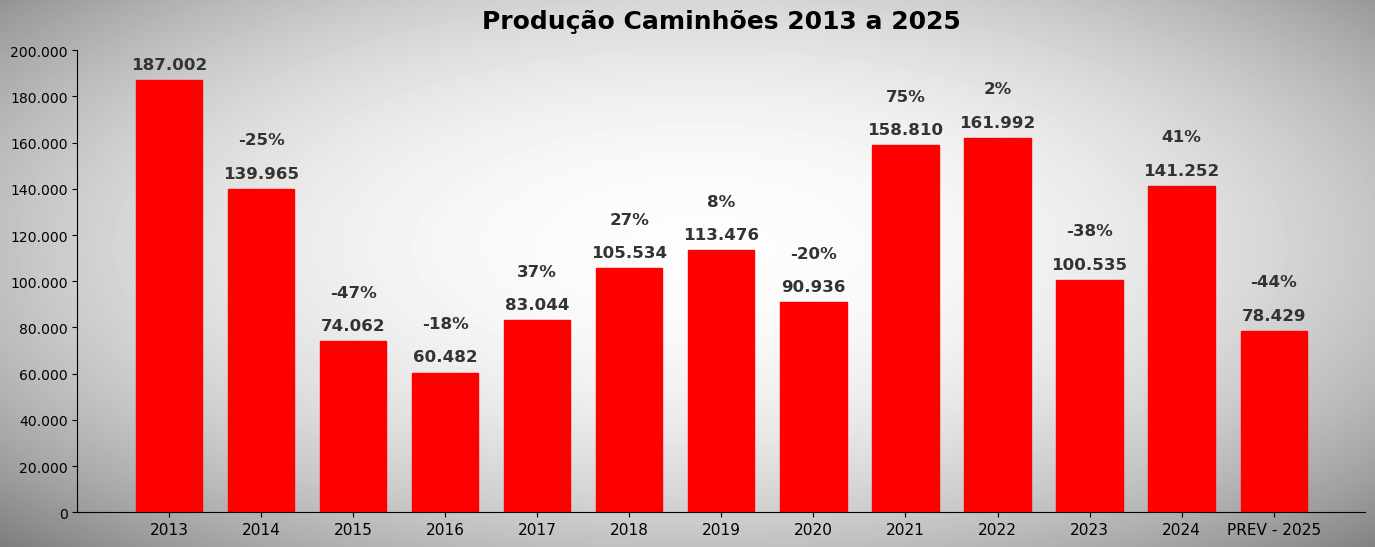

In [32]:
### GRAFICO DE BARRAS PRODUÇÃO DE CAMINHÃO X ANO
# garante ordem por ano
valores_prod_ano = valores_prod_ano.sort_index()
variacao_prod_ano = variacao_prod_ano.reindex(valores_prod_ano.index)

# formatação "187.002"
fmt_milhar_pt = lambda n: f"{int(round(n)):,}".replace(",", ".")

# rótulos do eixo X: anos como string
anos = [str(a) for a in valores_prod_ano.index.tolist()]
valores = valores_prod_ano.values.astype(float)

# variação em inteiros (primeiro None)
variacao = [None] + list(np.round(variacao_prod_ano.iloc[1:].values).astype("float"))
# (fica None no 1º ano e inteiros nos demais; exibe “-25%”, “27%”, etc.)

# Se quiser renomear 2025 para "PREV - 2025" (caso exista 2025 no seu índice):
if "2025" in anos:
    i = anos.index("2025")
    anos[i] = "PREV - 2025"


fig, ax = plt.subplots(figsize=(14, 6))

# ===== FUNDO EM TODA A FIGURA (gradiente cinza claro) =====
# pegue o tamanho real (em pixels) da figura para gerar o gradiente do mesmo tamanho
fig.canvas.draw()  # garante que largura/altura estejam atualizadas
fig_w, fig_h = fig.canvas.get_width_height()

# grade para gradiente radial
x = np.linspace(-1, 1, fig_w)
y = np.linspace(-1, 1, fig_h)
xx, yy = np.meshgrid(x, y)
radial = np.sqrt(xx**2 + yy**2)
radial = radial / radial.max()
radial = radial**2.2  # suaviza a transição

# centro quase branco, bordas só um pouco mais escuras (ajuste fino em base/amp)
base = 0.99   # quão claro é o centro (0=preto, 1=branco)
amp  = 0.5   # quão escuras as bordas ficam (quanto menor, mais claro)
bg = np.clip(base - amp * radial, 0, 1)

# deixa a figura e o eixo "transparentes" para o gradiente aparecer por trás
fig.patch.set_alpha(0)
ax.set_facecolor((1, 1, 1, 0))

# aplica o gradiente na figura inteira (cobre inclusive fora do eixo)
fig.figimage(bg, xo=0, yo=0, cmap="gray", vmin=0, vmax=1, zorder=-10)
# ===== FIM DO FUNDO =====



# barras vermelhas
barras = ax.bar(range(len(anos)), valores, color="#ff0000", edgecolor="#ff0000", width=0.72)

# título
ax.set_title("Produção Caminhões 2013 a 2025", fontsize=18, fontweight='bold', pad=16)

# eixo X
ax.set_xticks(range(len(anos)))
ax.set_xticklabels(anos, rotation=0, fontsize=11)

# eixo Y: 0–200.000 com passo 20.000
ax.set_ylim(0, 200000)
yticks = np.arange(0, 200001, 20000)
ax.set_yticks(yticks)
ax.set_yticklabels([fmt_milhar_pt(v) for v in yticks], fontsize=10)

# limpar bordas / grid
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# rótulos (valor e %)
for i, (rect, valor, var) in enumerate(zip(barras, valores, variacao)):
    x = rect.get_x() + rect.get_width()/2
    y = rect.get_height()
    # valor logo acima da barra, em negrito
    ax.text(x, y + 3500, fmt_milhar_pt(valor), ha='center', va='bottom',
            fontsize=12, fontweight='bold', color="#333333")
    # variação % (se houver), ainda mais acima
    if var is not None and not np.isnan(var):
        ax.text(x, y + 18000, f"{int(var)}%", ha='center', va='bottom',
                fontsize=12, fontweight='bold', color="#333333")

plt.subplots_adjust(left=0.06, right=0.98, top=0.90, bottom=0.13)
plt.show()

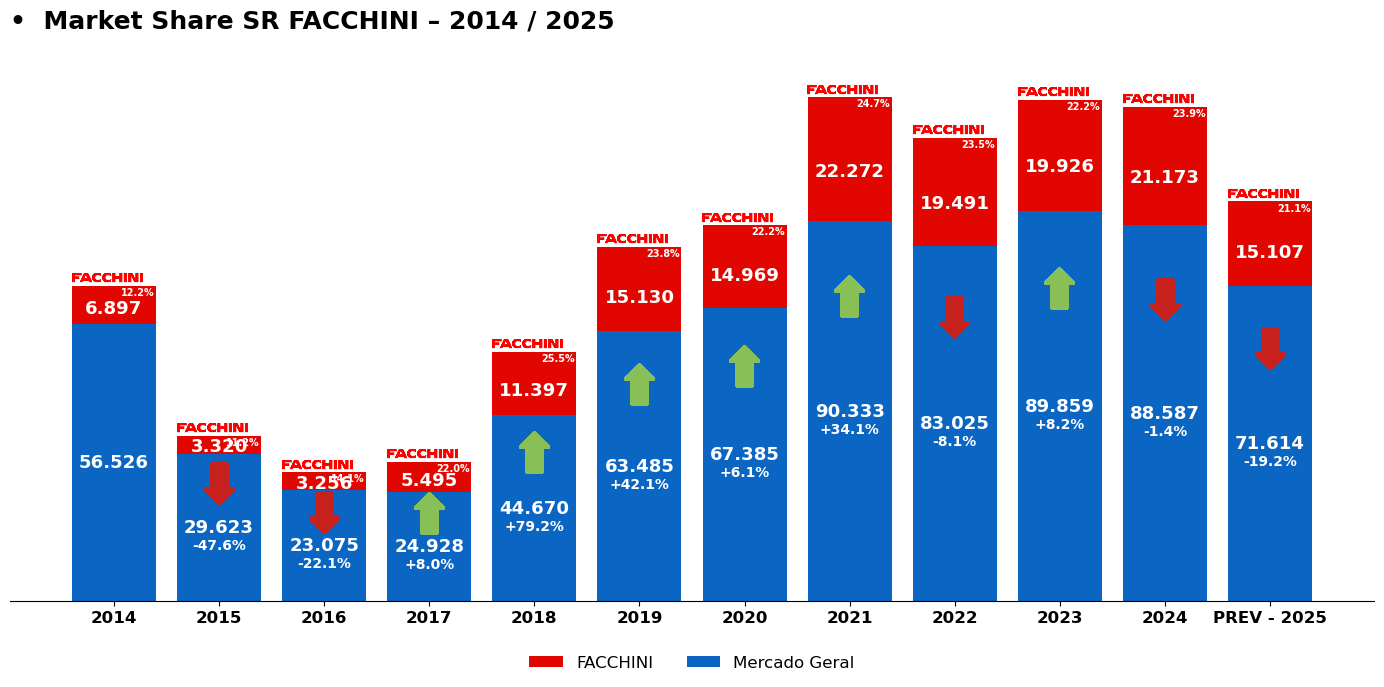

In [33]:

# ======== DADOS (a partir da sua tabela) ========
totais = tabela_sr["Total_Geral"].astype(float).copy()
fac    = tabela_sr["Total_Facchini"].astype(float).reindex(totais.index, fill_value=0)
outros = (totais - fac).clip(lower=0)

LOGO_PATH = "arquivos/logoprincipal.png"   # troque se estiver em outro caminho
LOGO_ZOOM = 0.22               # ajuste o tamanho da logo aqui

# arquivos das setas 
ARROW_UP_PATH   = "arquivos/seta-verde-para-cima.png"
ARROW_DOWN_PATH = "arquivos/seta-vermelha-para-baixo.png"
FRACT_DENTRO_AZUL = 0.8   # altura-alvo dentro do azul (0=base azul, 1=topo azul)
ARROW_ZOOM   = 0.06        # tamanho da seta
ARROW_SHIFT  = (0, 0)      # deslocamento extra da seta em points (x,y)
PCT_SHIFT    = (0, -50)     # deslocamento do texto % em points RELATIVO à seta
PCT_ALIGN    = ("center", "top")  # (ha, va) do texto %

# ---- posicionamento do % (variação YoY) ----
PCT_REF   = "azul"      # "azul" (alinha ao valor do bloco azul) ou "seta" (comporta-se como antes)
PCT_POS   = "above"     # "below" = abaixo da referência | "above" = acima da referência
PCT_DIST  = 18          # distância (em points) entre o % e a referência escol

_img_up = plt.imread(ARROW_UP_PATH)
_img_down = plt.imread(ARROW_DOWN_PATH)
logo_img = plt.imread(LOGO_PATH)

anos = totais.index.to_list()

# métricas
share_fac = np.where(totais.values>0, (fac.values / totais.values) * 100, np.nan)
var_tot   = np.r_[np.nan, np.diff(totais.values) / totais.values[:-1] * 100]  # % vs ano anterior

# ======== ESTILO ========
plt.rcParams.update({
    "font.size": 12,
    "axes.titleweight": "bold",
    "axes.titlesize": 18,
})

azul   = "#0B66C3"
vermelho = "#E10600"
branco = "#FFFFFF"
preto  = "#000000"
verde  = "#1FA650"

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor("white")

# ======== BARRAS ========
bars_azul = ax.bar(anos, outros, color=azul, edgecolor="none")
bars_verm = ax.bar(anos, fac, bottom=outros, color=vermelho, edgecolor="none")

# ======== RÓTULOS (como na imagem 2) ========

for i, ano in enumerate(anos):
    y_outros = outros.iloc[i]
    y_fac    = fac.iloc[i]
    y_total  = totai = totais.iloc[i]
    topo     = y_outros + y_fac
    
    # 2) Dentro do azul: valor do mercado (azul) em branco, centralizado
    if y_outros > 0:
        ax.text(ano, y_outros/2, f"{int(round(y_total,0)):,}".replace(",","."), 
                ha="center", va="center", fontsize=13, fontweight="bold", color=branco)

    # 3) Faixa vermelha: título FACCHINI + valor em branco
    if y_fac > 0:
        # valor FACCHINI no meio da faixa
        ax.text(ano, y_outros + y_fac*0.4, f"{int(round(y_fac,0)):,}".replace(",","."), 
                ha="center", va="center", fontsize=13, fontweight="bold", color=branco)
        # 4) % de share acima da palavra (ou logo abaixo do topo vermelho)
        ax.annotate(
            f"{share_fac[i]:.1f}%",
            xy=(ano, topo),
            xytext=(5, -1),              # -8 p/ esquerda, -4 p/ baixo
            textcoords="offset points",
            ha="left", va="top",
            fontsize=7, fontweight="bold", color=branco,
            clip_on=True
        )
        # === LOGO no topo da barra ===
        ab = AnnotationBbox(
            OffsetImage(logo_img, zoom=LOGO_ZOOM),
            (ano, topo),                   # âncora: topo da barra
            frameon=False,
            boxcoords="offset points",     # deslocar em pontos de tela
            xybox=(0, 1),                  # 6 pts acima do topo
            box_alignment=(0.6, 0.0)       # alinhar a base da logo no topo da barra
        )
        ax.add_artist(ab)

# ======== Variação YoY com setas (como na imagem 2) ========
for i, ano in enumerate(anos):
    if i == 0 or np.isnan(var_tot[i]): 
        continue

    y_outros = outros.iloc[i]
    y_total  = totais.iloc[i]

    # ancora "dentro" do bloco azul
    if y_outros > 0:
        y_anchor = FRACT_DENTRO_AZUL * y_outros
    else:
        y_anchor = FRACT_DENTRO_AZUL * y_total

    up        = var_tot[i] >= 0
    seta_img  = _img_up if up else _img_down
    cor_texto = verde if up else vermelho

        # --- seta (PNG) ---
    ab = AnnotationBbox(
        OffsetImage(seta_img, zoom=ARROW_ZOOM),
        (ano, y_anchor),
        frameon=False,
        xybox=ARROW_SHIFT,               # ajuste fino da seta
        boxcoords="offset points",
        box_alignment=(0.5, 0.5),
        clip_on=True
    )
    ax.add_artist(ab)

    # --- texto da % (ALINHADO ao valor do bloco azul ou à seta, conforme PCT_REF) ---
    # referência vertical para alinhar o %:
    if PCT_REF == "azul":
        # usa o mesmo y do rótulo do mercado (bloco azul)
        y_ref_pct = (y_outros/2) if y_outros > 0 else (0.5 * y_total)
    else:
        # mantém o comportamento antigo: referencia na seta
        y_ref_pct = y_anchor

    # decide acima/abaixo e a distância
    if PCT_POS.lower() == "below":
        va_pct = "top"       # âncora no topo do texto => texto aparece para baixo
        dy     = +PCT_DIST
    else:
        va_pct = "bottom"    # âncora na base do texto => texto aparece para cima
        dy     = -PCT_DIST

    ax.annotate(
        f"{var_tot[i]:+,.1f}%".replace(",", "."),
        xy=(ano, y_ref_pct),             # âncora em x=centro da barra e y=referência escolhida
        xytext=(0, dy),                  # distância controlada em points
        textcoords="offset points",
        ha="center", va=va_pct,          # centralizado no x da barra; acima/abaixo conforme PCT_POS
        fontsize=10, fontweight="bold",
        color= branco,
        clip_on=True
    )


# ======== TÍTULOS/LEGENDAS ========
ax.set_title("•  Market Share SR FACCHINI – 2014 / 2025", loc="left")
# legenda simples com caixas coloridas
leg_azul = Patch(facecolor=azul, label="Mercado Geral")
leg_verm = Patch(facecolor=vermelho, label="FACCHINI")
ax.legend(handles=[leg_verm, leg_azul], loc="lower center", frameon=False, bbox_to_anchor=(0.5, -0.15), ncol = 2)

# ======== EIXOS ========
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks(anos)
ax.set_xticklabels([f"PREV - 2025" if a == ano_atual else str(a) for a in anos], fontproperties=fm.FontProperties(weight='bold'))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_yticks([])  # sem grade/valores no eixo Y para ficar igual ao design
ax.margins(x=0.05, y=0.12)

plt.tight_layout()
plt.show()

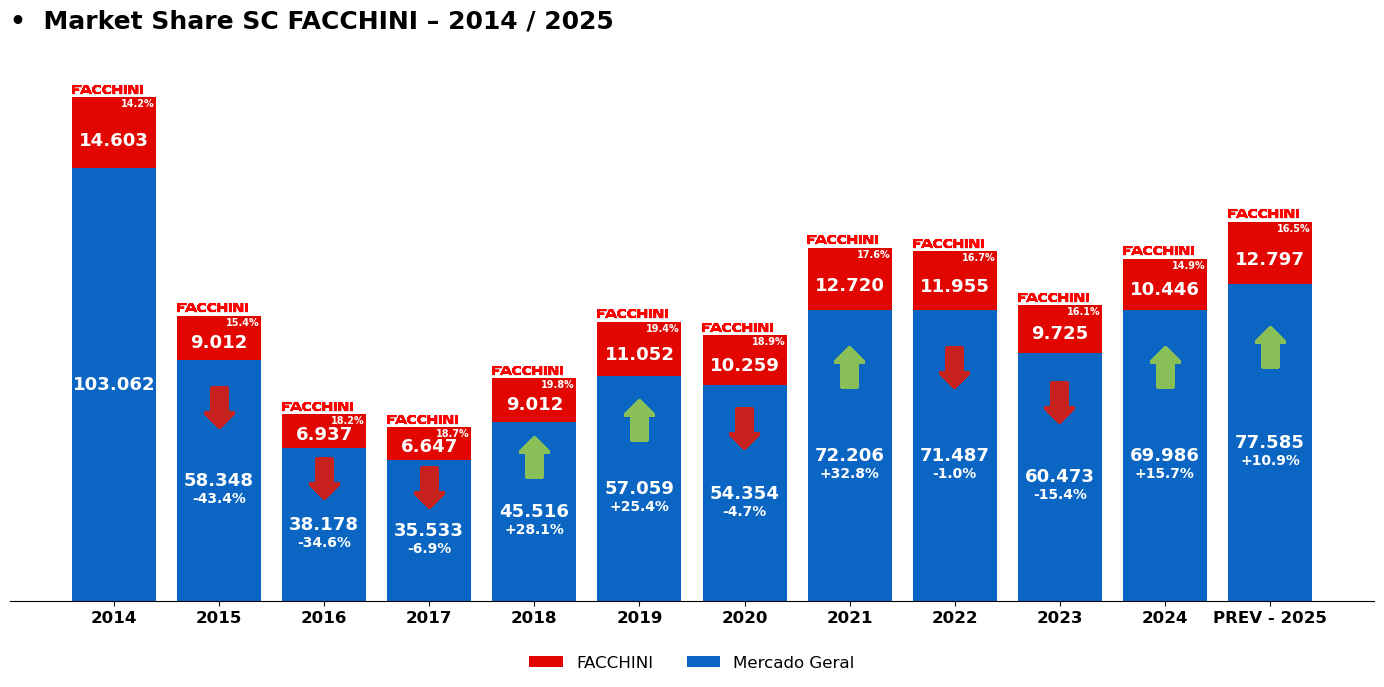

In [34]:

# ======== DADOS (a partir da sua tabela) ========
totais = tabela_sc["Total_Geral"].astype(float).copy()
fac    = tabela_sc["Total_Facchini"].astype(float).reindex(totais.index, fill_value=0)
outros = (totais - fac).clip(lower=0)

LOGO_PATH = "arquivos/logoprincipal.png"   # troque se estiver em outro caminho
LOGO_ZOOM = 0.22               # ajuste o tamanho da logo aqui

# arquivos das setas 
ARROW_UP_PATH   = "arquivos/seta-verde-para-cima.png"
ARROW_DOWN_PATH = "arquivos/seta-vermelha-para-baixo.png"
FRACT_DENTRO_AZUL = 0.8   # altura-alvo dentro do azul (0=base azul, 1=topo azul)
ARROW_ZOOM   = 0.06        # tamanho da seta
ARROW_SHIFT  = (0, 0)      # deslocamento extra da seta em points (x,y)
PCT_SHIFT    = (0, -50)     # deslocamento do texto % em points RELATIVO à seta
PCT_ALIGN    = ("center", "top")  # (ha, va) do texto %

# ---- posicionamento do % (variação YoY) ----
PCT_REF   = "azul"      # "azul" (alinha ao valor do bloco azul) ou "seta" (comporta-se como antes)
PCT_POS   = "above"     # "below" = abaixo da referência | "above" = acima da referência
PCT_DIST  = 18          # distância (em points) entre o % e a referência escol

_img_up = plt.imread(ARROW_UP_PATH)
_img_down = plt.imread(ARROW_DOWN_PATH)
logo_img = plt.imread(LOGO_PATH)

anos = totais.index.to_list()

# métricas
share_fac = np.where(totais.values>0, (fac.values / totais.values) * 100, np.nan)
var_tot   = np.r_[np.nan, np.diff(totais.values) / totais.values[:-1] * 100]  # % vs ano anterior

# ======== ESTILO ========
plt.rcParams.update({
    "font.size": 12,
    "axes.titleweight": "bold",
    "axes.titlesize": 18,
})

azul   = "#0B66C3"
vermelho = "#E10600"
branco = "#FFFFFF"
preto  = "#000000"
verde  = "#1FA650"

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor("white")

# ======== BARRAS ========
bars_azul = ax.bar(anos, outros, color=azul, edgecolor="none")
bars_verm = ax.bar(anos, fac, bottom=outros, color=vermelho, edgecolor="none")

# ======== RÓTULOS (como na imagem 2) ========

for i, ano in enumerate(anos):
    y_outros = outros.iloc[i]
    y_fac    = fac.iloc[i]
    y_total  = totai = totais.iloc[i]
    topo     = y_outros + y_fac
    
    # 2) Dentro do azul: valor do mercado (azul) em branco, centralizado
    if y_outros > 0:
        ax.text(ano, y_outros/2, f"{int(round(y_total,0)):,}".replace(",","."), 
                ha="center", va="center", fontsize=13, fontweight="bold", color=branco)

    # 3) Faixa vermelha: título FACCHINI + valor em branco
    if y_fac > 0:
        # valor FACCHINI no meio da faixa
        ax.text(ano, y_outros + y_fac*0.4, f"{int(round(y_fac,0)):,}".replace(",","."), 
                ha="center", va="center", fontsize=13, fontweight="bold", color=branco)
        # 4) % de share acima da palavra (ou logo abaixo do topo vermelho)
        ax.annotate(
            f"{share_fac[i]:.1f}%",
            xy=(ano, topo),
            xytext=(5, -1),              # -8 p/ esquerda, -4 p/ baixo
            textcoords="offset points",
            ha="left", va="top",
            fontsize=7, fontweight="bold", color=branco,
            clip_on=True
        )
        # === LOGO no topo da barra ===
        ab = AnnotationBbox(
            OffsetImage(logo_img, zoom=LOGO_ZOOM),
            (ano, topo),                   # âncora: topo da barra
            frameon=False,
            boxcoords="offset points",     # deslocar em pontos de tela
            xybox=(0, 1),                  # 6 pts acima do topo
            box_alignment=(0.6, 0.0)       # alinhar a base da logo no topo da barra
        )
        ax.add_artist(ab)

# ======== Variação YoY com setas (como na imagem 2) ========
for i, ano in enumerate(anos):
    if i == 0 or np.isnan(var_tot[i]): 
        continue

    y_outros = outros.iloc[i]
    y_total  = totais.iloc[i]

    # ancora "dentro" do bloco azul
    if y_outros > 0:
        y_anchor = FRACT_DENTRO_AZUL * y_outros
    else:
        y_anchor = FRACT_DENTRO_AZUL * y_total

    up        = var_tot[i] >= 0
    seta_img  = _img_up if up else _img_down
    cor_texto = verde if up else vermelho

        # --- seta (PNG) ---
    ab = AnnotationBbox(
        OffsetImage(seta_img, zoom=ARROW_ZOOM),
        (ano, y_anchor),
        frameon=False,
        xybox=ARROW_SHIFT,               # ajuste fino da seta
        boxcoords="offset points",
        box_alignment=(0.5, 0.5),
        clip_on=True
    )
    ax.add_artist(ab)

    # --- texto da % (ALINHADO ao valor do bloco azul ou à seta, conforme PCT_REF) ---
    # referência vertical para alinhar o %:
    if PCT_REF == "azul":
        # usa o mesmo y do rótulo do mercado (bloco azul)
        y_ref_pct = (y_outros/2) if y_outros > 0 else (0.5 * y_total)
    else:
        # mantém o comportamento antigo: referencia na seta
        y_ref_pct = y_anchor

    # decide acima/abaixo e a distância
    if PCT_POS.lower() == "below":
        va_pct = "top"       # âncora no topo do texto => texto aparece para baixo
        dy     = +PCT_DIST
    else:
        va_pct = "bottom"    # âncora na base do texto => texto aparece para cima
        dy     = -PCT_DIST

    ax.annotate(
        f"{var_tot[i]:+,.1f}%".replace(",", "."),
        xy=(ano, y_ref_pct),             # âncora em x=centro da barra e y=referência escolhida
        xytext=(0, dy),                  # distância controlada em points
        textcoords="offset points",
        ha="center", va=va_pct,          # centralizado no x da barra; acima/abaixo conforme PCT_POS
        fontsize=10, fontweight="bold",
        color= branco,
        clip_on=True
    )


# ======== TÍTULOS/LEGENDAS ========
ax.set_title("•  Market Share SC FACCHINI – 2014 / 2025", loc="left")
# legenda simples com caixas coloridas
leg_azul = Patch(facecolor=azul, label="Mercado Geral")
leg_verm = Patch(facecolor=vermelho, label="FACCHINI")
ax.legend(handles=[leg_verm, leg_azul], loc="lower center", frameon=False, bbox_to_anchor=(0.5, -0.15), ncol = 2)

# ======== EIXOS ========
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks(anos)
ax.set_xticklabels([f"PREV - 2025" if a == ano_atual else str(a) for a in anos], fontproperties=fm.FontProperties(weight='bold'))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_yticks([])  # sem grade/valores no eixo Y para ficar igual ao design
ax.margins(x=0.05, y=0.12)

plt.tight_layout()
plt.show()

C:\Users\gsribeiro\AppData\Local\Temp\ipykernel_10568\2072682523.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '149198.6666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  total_ano.loc[ano_atual] = prev_total


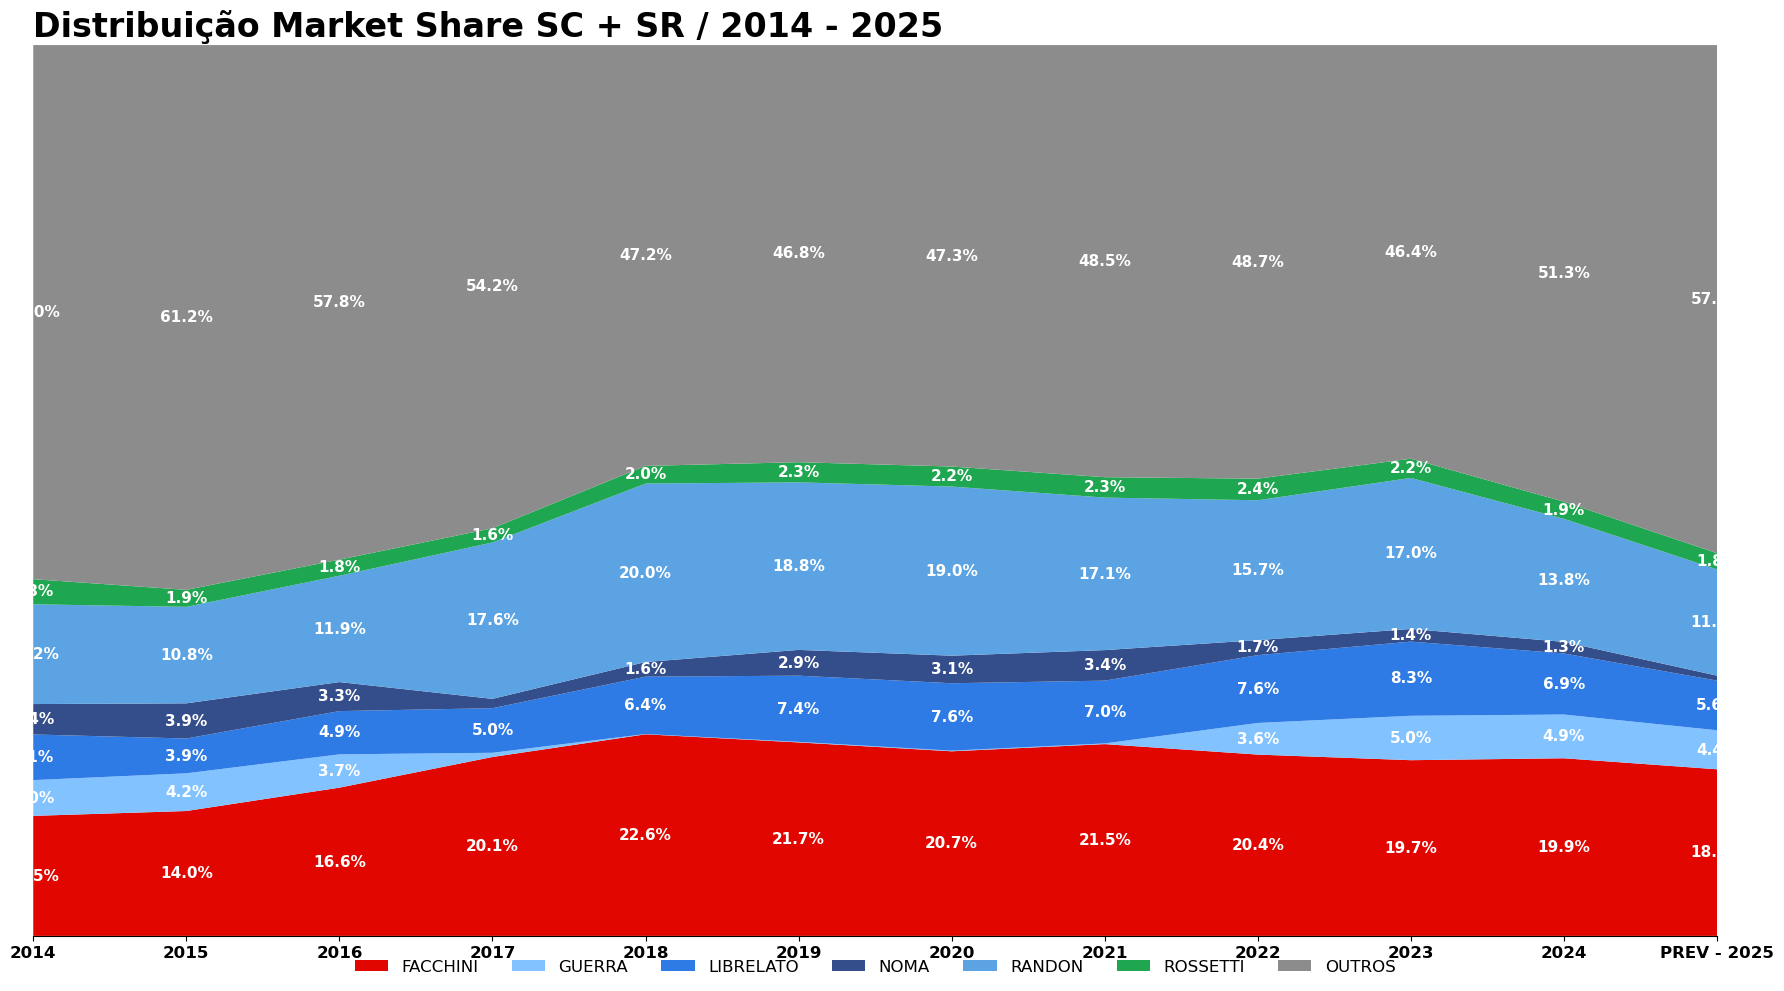

In [35]:
# ---- Marcas e cores iguais à arte ----
MARCAS = ["FACCHINI","GUERRA","LIBRELATO","NOMA","RANDON","ROSSETTI"]
CORES  = {
    "FACCHINI":"#E10600", "GUERRA":"#82C3FF", "LIBRELATO":"#2E7BE6",
    "NOMA":"#334E8A", "RANDON":"#5BA3E3", "ROSSETTI":"#1FA650", "OUTROS":"#8C8C8C"
}

def shares_por_ano(df_base: pd.DataFrame, ano_atual: int) -> pd.DataFrame:
    """Retorna DataFrame (index=ano) com % por marca + OUTROS (100%), já incluindo PREV do ano atual."""
    df1 = df_base.copy()
    df1["Qtde"] = pd.to_numeric(df1["Qtde"], errors="coerce").fillna(0)
    df1["Ano"]  = pd.to_numeric(df1["Ano"],  errors="coerce").astype(int)
    df1["Implementadora"] = df1["Implementadora"].str.upper().str.strip()

    # Totais históricos
    total_ano = df1.groupby("Ano")["Qtde"].sum().sort_index()

    # Totais por marca (histórico)
    por_marca = (
        df1[df1["Implementadora"].isin(MARCAS)]
        .groupby(["Ano","Implementadora"])["Qtde"].sum()
        .unstack("Implementadora")
        .reindex(total_ano.index, fill_value=0)
        .astype(float)
    )
    # Garante todas as colunas (se alguma marca não existir no período)
    for m in MARCAS:
        if m not in por_marca.columns:
            por_marca[m] = 0.0
    por_marca = por_marca[MARCAS]

    # ------ PREVISÃO para o ano atual (total e por marca), usando sua função ------
    # Total (todas as implementadoras)
    prev_total = previsao_media3m(df1, ano_atual, implementadora=None)
    # Por marca
    prev_marca = {}
    for m in MARCAS:
        prev_marca[m] = previsao_media3m(df1, ano_atual, implementadora=m)

    # Adiciona/atualiza a linha do ano atual com PREV
    if ano_atual not in total_ano.index:
        total_ano.loc[ano_atual] = 0
    total_ano.loc[ano_atual] = prev_total

    for m in MARCAS:
        if ano_atual not in por_marca.index:
            por_marca.loc[ano_atual] = 0
        por_marca.loc[ano_atual, m] = prev_marca[m]

    # Ordena por ano
    total_ano = total_ano.sort_index()
    por_marca = por_marca.sort_index()

    # ------ Converte para % e cria OUTROS ------
    shares = por_marca.div(total_ano.replace(0, np.nan), axis=0) * 100.0
    shares["OUTROS"] = (100.0 - shares.sum(axis=1)).clip(lower=0)
    shares = shares[MARCAS + ["OUTROS"]]  # ordem

    return shares

def plot_area_100(shares: pd.DataFrame, titulo: str, ano_atual: int):
    plt.rcParams.update({"font.size": 12, "axes.titleweight": "bold", "axes.titlesize": 24})
    anos = list(shares.index.astype(int))

    fig, ax = plt.subplots(figsize=(18, 10))
    ax.set_facecolor("white")

    cols = shares.columns.tolist()
    y = shares.to_numpy().T
    ax.stackplot(anos, y, colors=[CORES[c] for c in cols], linewidth=0)

    # título à esquerda
    ax.set_title(titulo, loc="left")

    # eixo X/Y no estilo da arte
    ax.set_xlim(min(anos), max(anos))
    ax.set_ylim(0, 100)
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.set_xticks(anos)
    ax.set_xticklabels([f"PREV - {ano_atual}" if a == ano_atual else str(a) for a in anos],
                       fontproperties=fm.FontProperties(weight='bold'))
    ax.set_yticks([])
    for s in ["top","right","left"]:
        ax.spines[s].set_visible(False)

    # legenda na base
    handles = [Patch(facecolor=CORES[c], label=c) for c in cols]
    ax.legend(handles=handles, loc="lower center", frameon=False,
              bbox_to_anchor=(0.5, -0.06), ncol=min(8, len(cols)))

    # rótulos dentro das faixas
    min_label = 1.2
    vals = shares.to_numpy()
    cum = np.zeros(len(anos))
    for j, name in enumerate(cols):
        seg = vals[:, j]
        centers = cum + seg/2
        for i, ano in enumerate(anos):
            v = seg[i]
            if np.isnan(v) or v < min_label: 
                continue
            ax.text(ano, centers[i], f"{v:.1f}%",
                    ha="center", va="center", fontsize=11, fontweight="bold", color="#FFFFFF", clip_on=True)
        cum += seg

    plt.tight_layout()
    plt.show()

# ================== GERAR O GRÁFICO DIRETO DO df ==================
shares_sc_sr = shares_por_ano(df, ano_atual)  # usa SC+SR combinados
plot_area_100(shares_sc_sr, f"Distribuição Market Share SC + SR / {shares_sc_sr.index.min()} - {shares_sc_sr.index.max()}", ano_atual)

C:\Users\gsribeiro\AppData\Local\Temp\ipykernel_10568\2072682523.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '77584.66666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  total_ano.loc[ano_atual] = prev_total


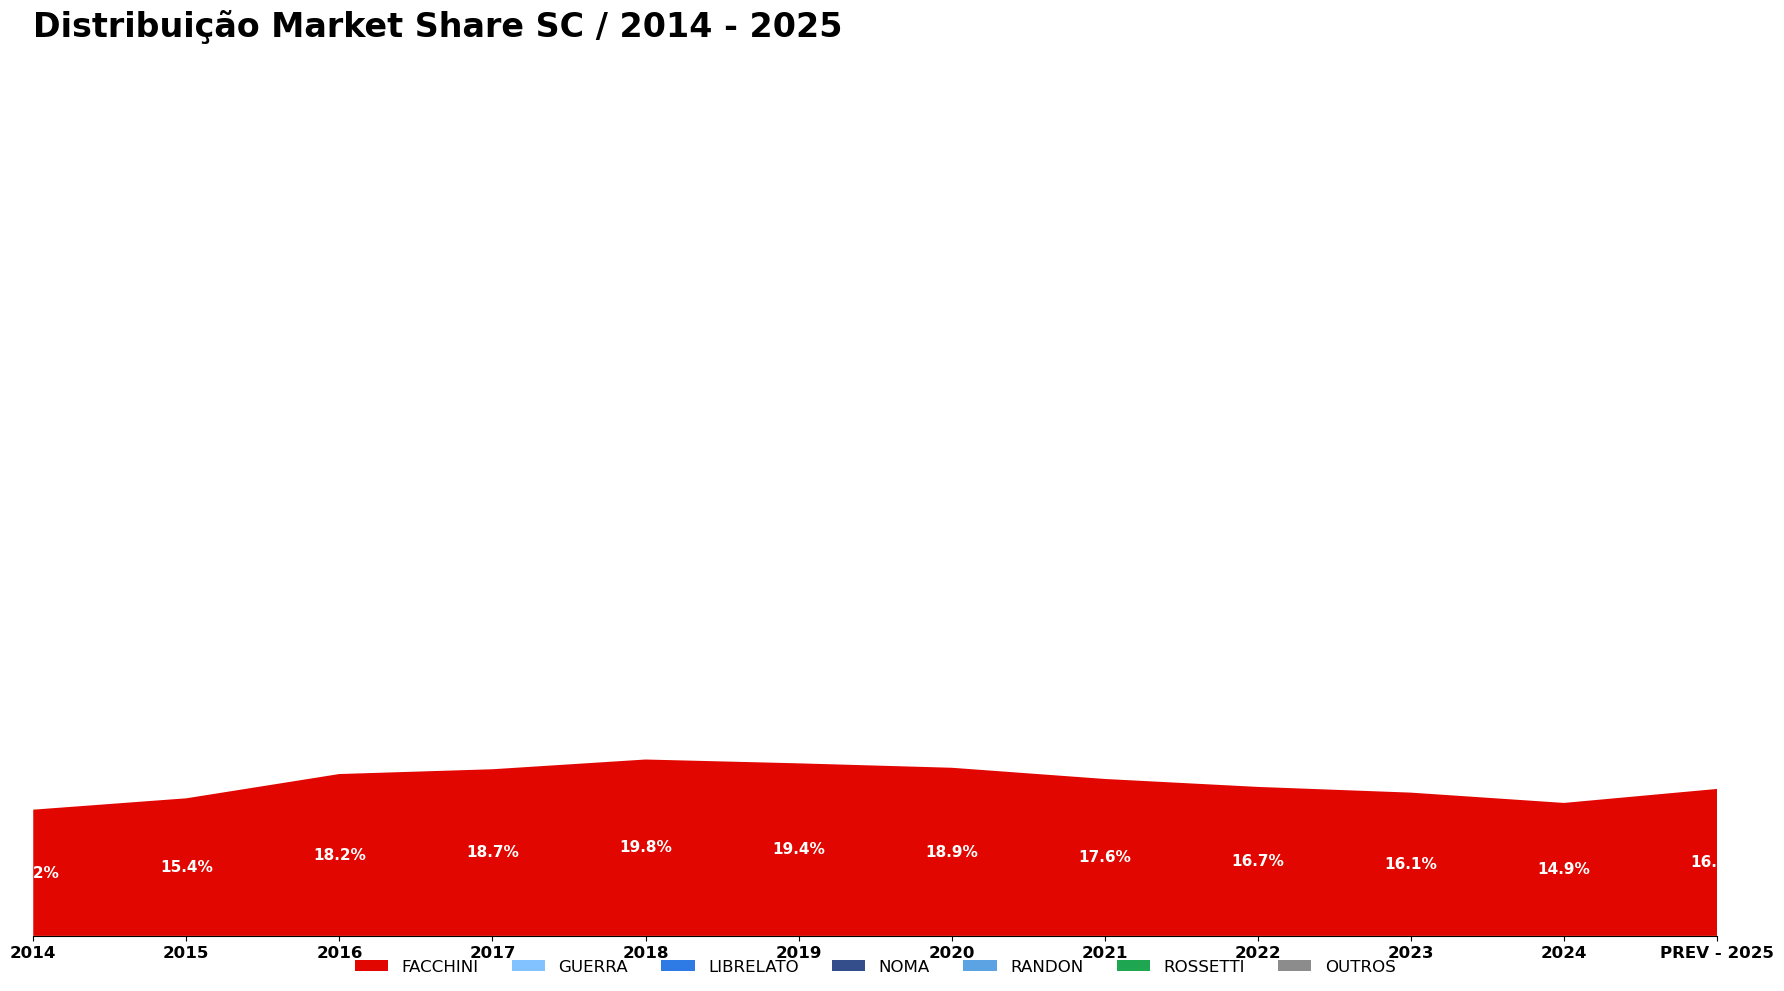

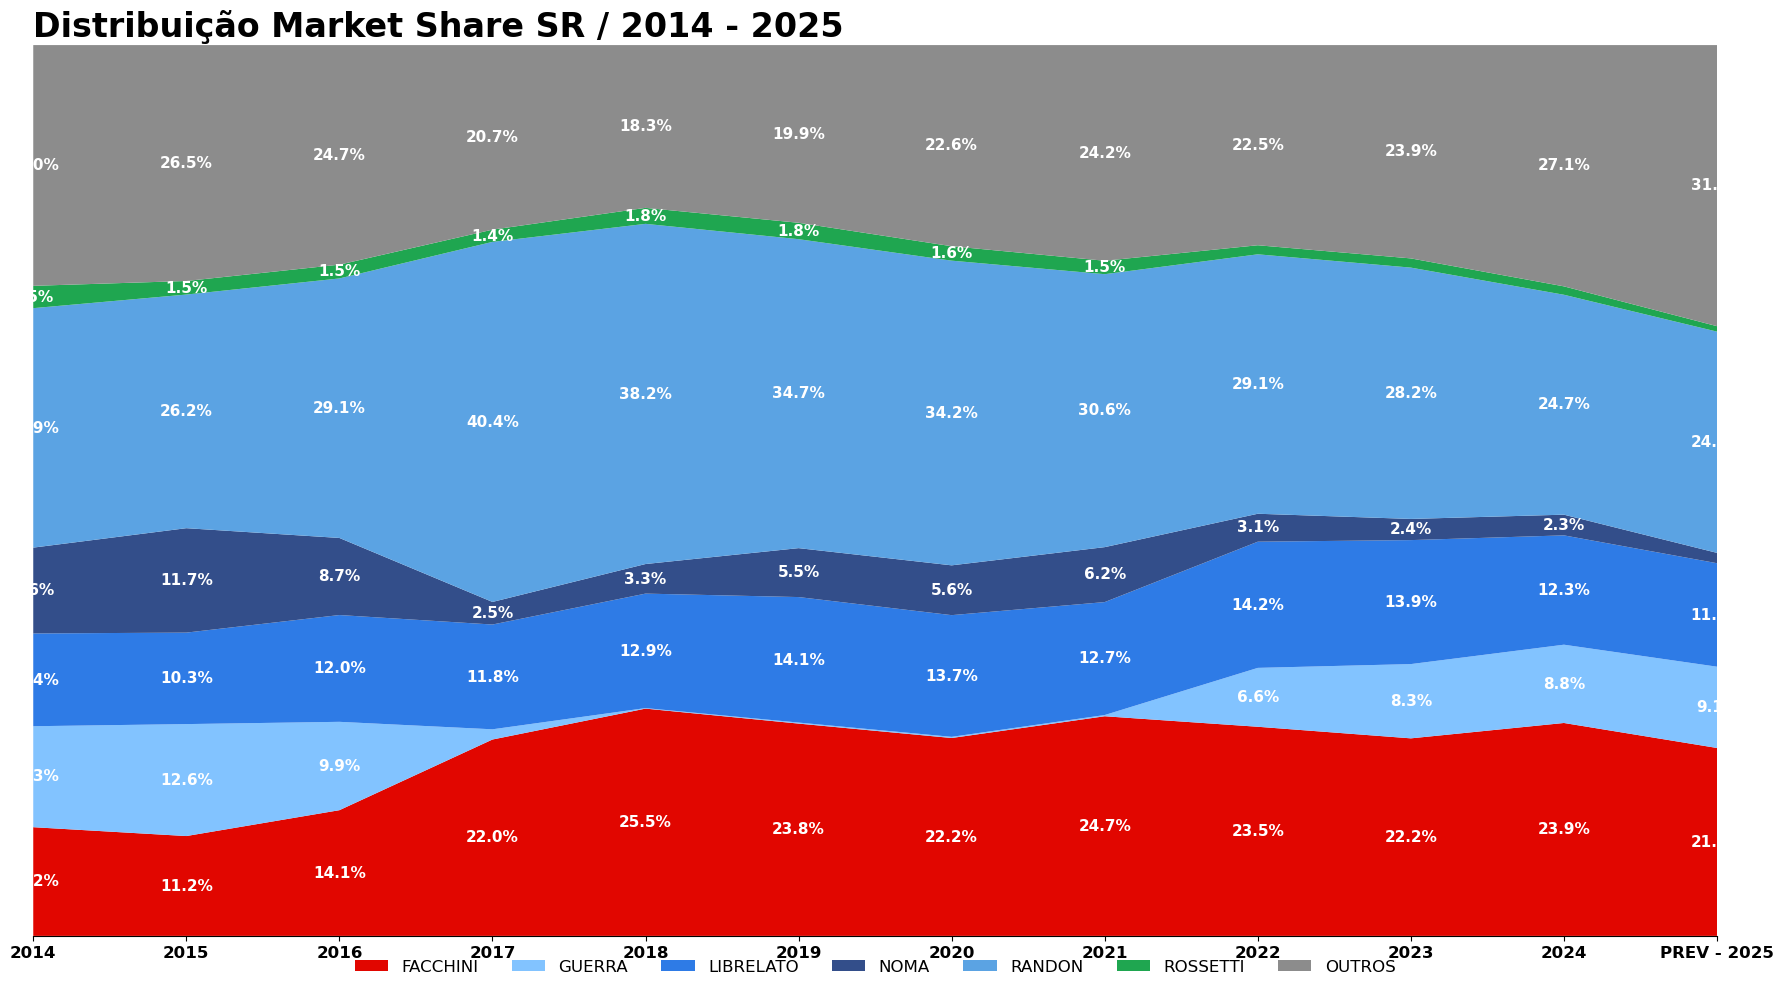

In [43]:
shares_sc = shares_por_ano(df_sc, ano_atual)
plot_area_100(shares_sc, f"Distribuição Market Share SC / {shares_sc.index.min()} - {shares_sc.index.max()}", ano_atual)
shares_sr = shares_por_ano(df_sr, ano_atual)
plot_area_100(shares_sr, f"Distribuição Market Share SR / {shares_sr.index.min()} - {shares_sr.index.max()}", ano_atual)

In [36]:
df_emplacamento.head(10)

,Tipo,UF,Cidade,Qtde,Implementadora,Mix Produto,Modelo,Cliente,Representante,Faturado,Data,Mes,Ano
0,SOBRE CHASSI,PA,JURUTI,1,ALLTECH VECULOS ESPECIAIS LTDA.,OUTROS,VW AMAROK CS 4X4 S,NaN,JOÃO ALEXANDRE CAINELO,59104422010384,2014-06-01,6,2014
1,SOBRE CHASSI,SP,SAO PAULO,1,ALLTECH VECULOS ESPECIAIS LTDA.,OUTROS,VW AMAROK CS 4X4 S,NaN,WASHINGTON - RENATO - MARIO - CLEDSON,59104422010384,2014-02-01,2,2014
2,SOBRE CHASSI,GO,CATALAO,3,CLC INDSTRIA E COMERCIO DE PEAAS,BAU CARGA GERAL,VW AMAROK CS 4X4 S,NaN,RODRIGO GALHEGO CARVALHO,59104422010384,2014-05-01,5,2014
3,SOBRE CHASSI,MG,CATAGUASES,7,EMBARK,GRANELEIRO/CARGA SECA,VW AMAROK CS 4X4 S,NaN,ADAIR,59104422010384,2014-06-01,6,2014
4,SOBRE CHASSI,PB,JOAO PESSOA,8,EMBARK,GRANELEIRO/CARGA SECA,VW AMAROK CS 4X4 S,NaN,LUCIANO GILSON CRUZ DE OLIVEIRA,59104422010384,2014-11-01,11,2014
5,SOBRE CHASSI,RJ,NOVA FRIBURGO,2,EMBARK,GRANELEIRO/CARGA SECA,VW AMAROK CS 4X4 S,NaN,ADAUTO WASHINGTON MIGLIOLI,59104422010384,2014-06-01,6,2014
6,SOBRE CHASSI,SP,SAO PAULO,9,EMBARK,GRANELEIRO/CARGA SECA,VW AMAROK CS 4X4 S,NaN,WASHINGTON - RENATO - MARIO - CLEDSON,59104422010384,2014-11-01,11,2014
7,SOBRE CHASSI,SP,SAO PAULO,4,EMBARK,GRANELEIRO/CARGA SECA,VW AMAROK CS 4X4 S,NaN,WASHINGTON - RENATO - MARIO - CLEDSON,59104422010384,2014-12-01,12,2014
8,SOBRE CHASSI,SP,SAO PAULO,1,GREENCAR VECULOS ESPECIAIS PEAAS E SERVIAOS,OUTROS,VW AMAROK CS 4X4 S,NaN,WASHINGTON - RENATO - MARIO - CLEDSON,59104422010384,2014-05-01,5,2014
9,SOBRE CHASSI,SP,SAO PAULO,2,GREENCAR VECULOS ESPECIAIS PEAAS E SERVIAOS,OUTROS,VW AMAROK CS 4X4 S,NaN,WASHINGTON - RENATO - MARIO - CLEDSON,59104422010384,2014-11-01,11,2014


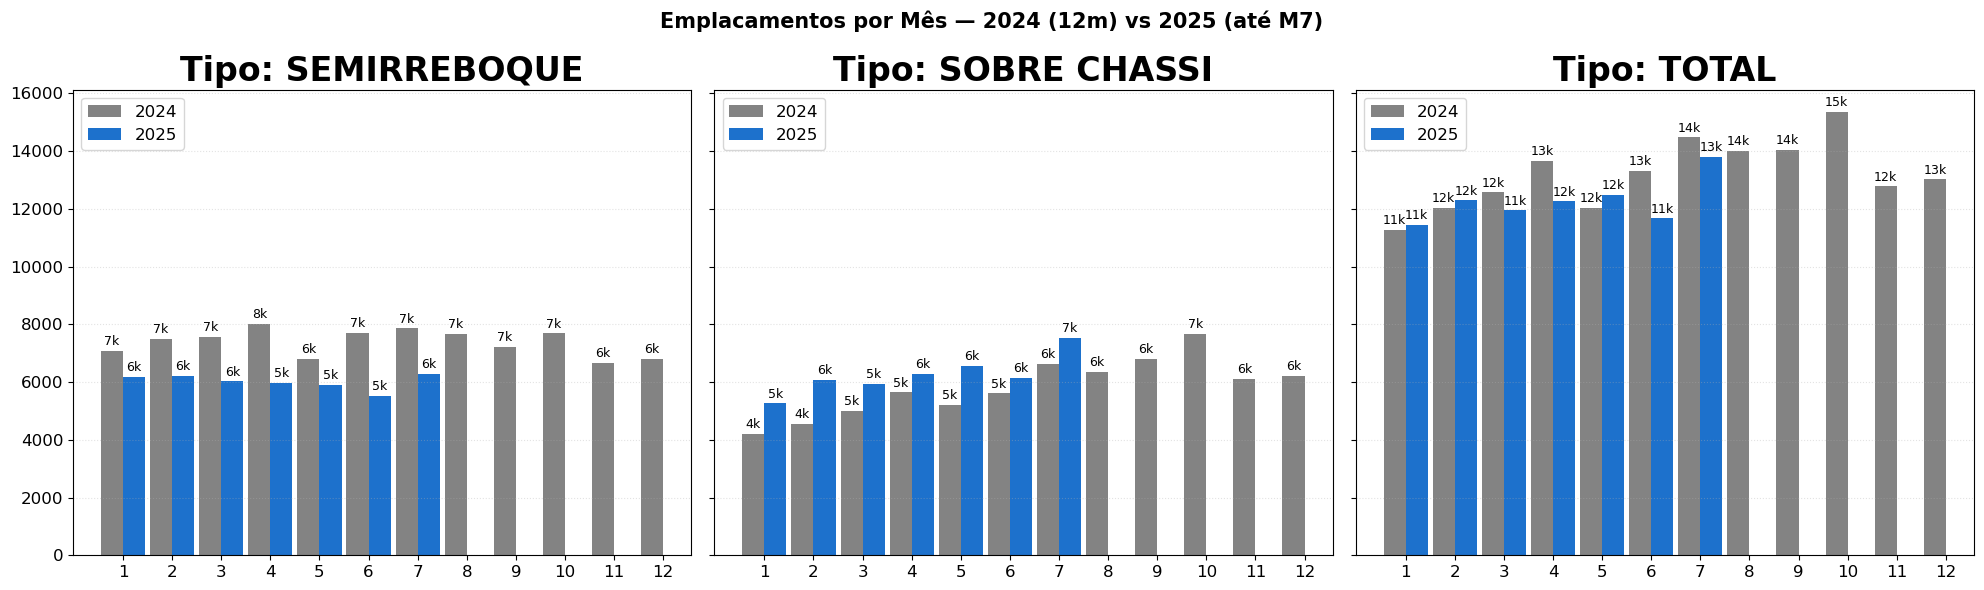

In [37]:
###DADOS ANALISE MENSAL

# ===divide por 1000 e adiciona 'mil'===
def fmt_val(v):
    if v >= 1000:
        return f"{int(v/1000)}k"
    return str(int(v))

# 1) Base
df = df_emplacamento.copy()
df = df[(df['Ano'] >= 2024) & (~df['Tipo'].isna())]
df['Qtde'] = pd.to_numeric(df['Qtde'], errors='coerce').fillna(0)
df['Mes']  = pd.to_numeric(df['Mes'],  errors='coerce').astype('Int64')

ano_max  = int(df['Ano'].max())      # ex.: 2025
ano_prev = ano_max - 1               # ex.: 2024
mes_limite_atual = 7                 # até julho para o ano atual

# 2) Agregação por tipo (mensal)
por_tipo = (
    df[df['Ano'].isin([ano_prev, ano_max])]
      .groupby(['Ano', 'Mes', 'Tipo'], as_index=False)['Qtde']
      .sum()
)

# 3) Agregação total (mensal)
total = (
    df[df['Ano'].isin([ano_prev, ano_max])]
      .groupby(['Ano', 'Mes'], as_index=False)['Qtde']
      .sum()
      .assign(Tipo='TOTAL')
)[['Ano','Mes','Tipo','Qtde']]

# 4) Combina
dados = pd.concat([por_tipo, total], ignore_index=True)

# 5) Função de rótulo (milhar com ponto)
# def fmt_val(v):
#     return f"{v:,.0f}".replace(',', '.')

# 6) Tipos (TOTAL por último)
tipos_base = [t for t in dados['Tipo'].dropna().unique() if t != 'TOTAL']
tipos = sorted(tipos_base) + ['TOTAL']

# 7) Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
if isinstance(axes, np.ndarray) is False:  # segurança caso só 1 eixo
    axes = np.array([axes])

cores = {
    ano_prev: "#838383",  # cinza
    ano_max:  "#1d71cc",  # azul
}

for i, tipo in enumerate(tipos[:3]):  # garante 3 painéis (2 tipos + TOTAL)
    ax  = axes[i]
    sub = dados[dados['Tipo'] == tipo].copy()

    # séries por ano
    s_prev = (sub[sub['Ano'] == ano_prev]
              .set_index('Mes')
              .reindex(range(1, 13), fill_value=0)        # 12 meses
              .reset_index())
    s_max  = (sub[(sub['Ano'] == ano_max) & (sub['Mes'] <= mes_limite_atual)]
              .set_index('Mes')
              .reindex(range(1, mes_limite_atual+1), fill_value=0)  # até M7
              .reset_index())

    # eixos X e largura
    x_prev = np.arange(1, 13)
    x_max  = np.arange(1, mes_limite_atual+1)
    w = 0.45

    # barras
    bars_prev = ax.bar(x_prev - w/2, s_prev['Qtde'].to_numpy(),
                       width=w, label=str(ano_prev), color=cores[ano_prev])
    bars_max  = ax.bar(x_max  + w/2, s_max['Qtde'].to_numpy(),
                       width=w, label=str(ano_max),  color=cores[ano_max])

    #rótulos nas barras
    ax.bar_label(bars_prev,
                 labels=[fmt_val(v) for v in s_prev['Qtde']],
                 padding=2, fontsize=9)
    ax.bar_label(bars_max,
                 labels=[fmt_val(v) for v in s_max['Qtde']],
                 padding=2, fontsize=9)

    # ajustes visuais
    ax.set_title(f"Tipo: {tipo}", fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([f'{m}' for m in range(1, 13)])
    ax.grid(axis='y', linestyle=':', alpha=0.35)
    ax.legend(frameon=True, loc='upper left')

fig.suptitle(f'Emplacamentos por Mês — {ano_prev} (12m) vs {ano_max} (até M{mes_limite_atual})',
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

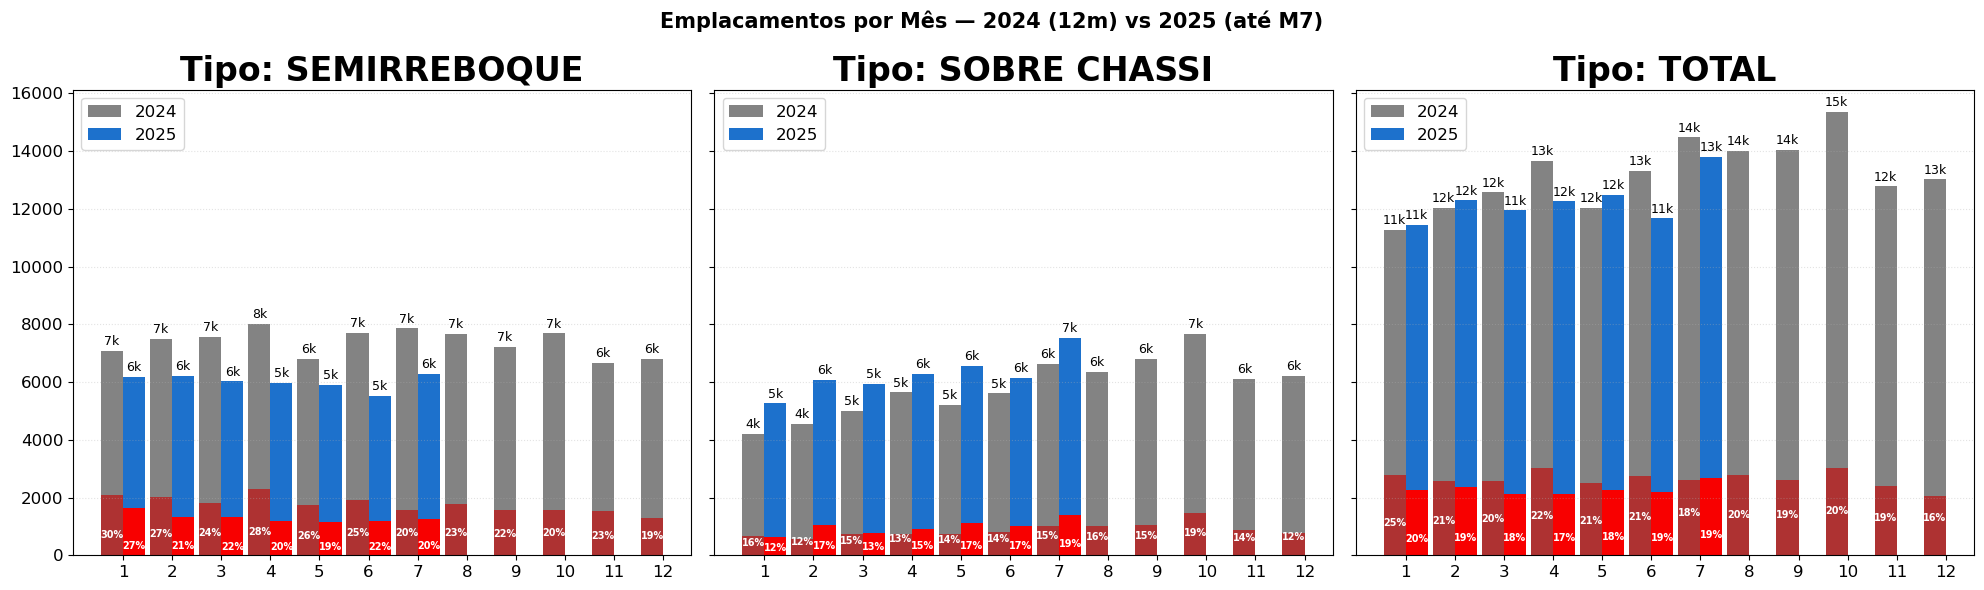

In [38]:
def fmt_val(v):
    if v >= 1000:
        return f"{int(v/1000)}k"
    return str(int(v))

# =========================
# 1) Base
# =========================
df = df_emplacamento.copy()

df = df[(df['Ano'] >= 2024) & (~df['Tipo'].isna())]
df['Qtde'] = pd.to_numeric(df['Qtde'], errors='coerce').fillna(0)
df['Mes']  = pd.to_numeric(df['Mes'],  errors='coerce').astype('Int64')
df['Implementadora'] = df.get('Implementadora', pd.Series(index=df.index)).astype(str).str.upper()

ano_max  = int(df['Ano'].max())      # ex.: 2025
ano_prev = ano_max - 1               # ex.: 2024
mes_limite_atual = 7

# =========================
# 2) Agregações
# =========================
# totais
por_tipo = (
    df[df['Ano'].isin([ano_prev, ano_max])]
      .groupby(['Ano', 'Mes', 'Tipo'], as_index=False)['Qtde']
      .sum()
)
total = (
    df[df['Ano'].isin([ano_prev, ano_max])]
      .groupby(['Ano', 'Mes'], as_index=False)['Qtde']
      .sum()
      .assign(Tipo='TOTAL')
)[['Ano','Mes','Tipo','Qtde']]
dados = pd.concat([por_tipo, total], ignore_index=True)

# facchini
facchini_tipo = (
    df[(df['Implementadora'] == 'FACCHINI') & (df['Ano'].isin([ano_prev, ano_max]))]
      .groupby(['Ano', 'Mes', 'Tipo'], as_index=False)['Qtde']
      .sum()
)
facchini_total = (
    df[(df['Implementadora'] == 'FACCHINI') & (df['Ano'].isin([ano_prev, ano_max]))]
      .groupby(['Ano', 'Mes'], as_index=False)['Qtde']
      .sum()
      .assign(Tipo='TOTAL')
)[['Ano','Mes','Tipo','Qtde']]
facchini_dados = pd.concat([facchini_tipo, facchini_total], ignore_index=True)

# =========================
# 3) Tipos
# =========================
tipos_base = [t for t in dados['Tipo'].dropna().unique() if t != 'TOTAL']
tipos = sorted(tipos_base) + ['TOTAL']

# =========================
# 4) Plot
# =========================
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
if isinstance(axes, np.ndarray) is False:
    axes = np.array([axes])

cores = {
    ano_prev: "#838383",  # cinza
    ano_max:  "#1d71cc",  # azul
}

for i, tipo in enumerate(tipos[:3]):
    ax  = axes[i]
    sub = dados[dados['Tipo'] == tipo].copy()
    fac = facchini_dados[facchini_dados['Tipo'] == tipo].copy()

    # séries totais
    s_prev = (sub[sub['Ano'] == ano_prev]
              .set_index('Mes')
              .reindex(range(1, 13), fill_value=0)
              .reset_index())
    s_max  = (sub[(sub['Ano'] == ano_max) & (sub['Mes'] <= mes_limite_atual)]
              .set_index('Mes')
              .reindex(range(1, mes_limite_atual+1), fill_value=0)
              .reset_index())

    # séries facchini
    f_prev = (fac[fac['Ano'] == ano_prev]
              .set_index('Mes')
              .reindex(range(1, 13), fill_value=0)
              .reset_index())
    f_max  = (fac[(fac['Ano'] == ano_max) & (fac['Mes'] <= mes_limite_atual)]
              .set_index('Mes')
              .reindex(range(1, mes_limite_atual+1), fill_value=0)
              .reset_index())

    # eixos
    x_prev = np.arange(1, 13)
    x_max  = np.arange(1, mes_limite_atual+1)
    w = 0.45

    # barras totais (base cinza/azul)
    bars_prev = ax.bar(x_prev - w/2, s_prev['Qtde'].to_numpy(),
                       width=w, label=str(ano_prev), color=cores[ano_prev])
    bars_max  = ax.bar(x_max  + w/2, s_max['Qtde'].to_numpy(),
                       width=w, label=str(ano_max),  color=cores[ano_max])
    
    # overlay facchini (em vermelho) — mesma barra, só que menor
    cores_facchini = {
        ano_prev: "#C900009E",  # vermelho escuro (DarkRed)
        ano_max:  "#F80000FF",  # vermelho mais claro
    }
    ax.bar(x_prev - w/2, f_prev['Qtde'].to_numpy(),
           width=w, color=cores_facchini[ano_prev])
    ax.bar(x_max + w/2, f_max['Qtde'].to_numpy(),
           width=w, color=cores_facchini[ano_max])

    # rótulos totais
    ax.bar_label(bars_prev, labels=[fmt_val(v) for v in s_prev['Qtde']], padding=2, fontsize=9)
    ax.bar_label(bars_max,  labels=[fmt_val(v) for v in s_max['Qtde']],  padding=2, fontsize=9)

    # opcional: % facchini escrito dentro da barra vermelha
    perc_prev = (f_prev['Qtde'] / s_prev['Qtde'].replace(0, np.nan)).fillna(0).to_numpy()
    perc_max  = (f_max['Qtde']  / s_max['Qtde'].replace(0, np.nan)).fillna(0).to_numpy()
    for x, total, p in zip(x_prev - w/2, s_prev['Qtde'].to_numpy(), perc_prev):
        if total > 0:
            ax.text(x, total*0.1, f"{p:.0%}", ha='center', va='center',
                    fontsize=7, color='white', fontweight='bold')
    for x, total, p in zip(x_max + w/2, s_max['Qtde'].to_numpy(), perc_max):
        if total > 0:
            ax.text(x, total*0.05, f"{p:.0%}", ha='center', va='center',
                    fontsize=7, color='white', fontweight='bold')

    ax.set_title(f"Tipo: {tipo}", fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([f'{m}' for m in range(1, 13)])
    ax.grid(axis='y', linestyle=':', alpha=0.35)
    ax.legend(frameon=True, loc='upper left')

fig.suptitle(f'Emplacamentos por Mês — {ano_prev} (12m) vs {ano_max} (até M{mes_limite_atual})',
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()



In [39]:
def fmt_val(v):
    if v >= 1000:
        return f"{int(v/1000)}k"
    return str(int(v))

# =========================
# 1) Base
# =========================
df = df_emplacamento.copy()
df = df[(df['Ano'] >= 2024) & (~df['Tipo'].isna())]
df['Qtde'] = pd.to_numeric(df['Qtde'], errors='coerce').fillna(0)
df['Mes']  = pd.to_numeric(df['Mes'],  errors='coerce').astype('Int64')
df['Implementadora'] = df.get('Implementadora', pd.Series(index=df.index)).astype(str).str.upper()

ano_max  = int(df['Ano'].max())      # ex.: 2025
ano_prev = ano_max - 1               # ex.: 2024
mes_limite_atual = 7

# =========================
# 2) Agregações
# =========================
# totais
por_tipo = (
    df[df['Ano'].isin([ano_prev, ano_max])]
      .groupby(['Ano', 'Mes', 'Tipo'], as_index=False)['Qtde']
      .sum()
)
total = (
    df[df['Ano'].isin([ano_prev, ano_max])]
      .groupby(['Ano', 'Mes'], as_index=False)['Qtde']
      .sum()
      .assign(Tipo='TOTAL')
)[['Ano','Mes','Tipo','Qtde']]
dados = pd.concat([por_tipo, total], ignore_index=True)

# facchini
facchini_tipo = (
    df[(df['Implementadora'] == 'FACCHINI') & (df['Ano'].isin([ano_prev, ano_max]))]
      .groupby(['Ano', 'Mes', 'Tipo'], as_index=False)['Qtde']
      .sum()
)
facchini_total = (
    df[(df['Implementadora'] == 'FACCHINI') & (df['Ano'].isin([ano_prev, ano_max]))]
      .groupby(['Ano', 'Mes'], as_index=False)['Qtde']
      .sum()
      .assign(Tipo='TOTAL')
)[['Ano','Mes','Tipo','Qtde']]
facchini_dados = pd.concat([facchini_tipo, facchini_total], ignore_index=True)

# =========================
# 3) Tipos
# =========================
tipos_base = [t for t in dados['Tipo'].dropna().unique() if t != 'TOTAL']
tipos = sorted(tipos_base) + ['TOTAL']

In [40]:

def plot_tipo(dados, facchini_dados, tipo, ano_prev, ano_max, mes_limite_atual):
    cores = {
        ano_prev: "#838383",  # cinza
        ano_max:  "#1d71cc",  # azul
    }
    cores_facchini = {
        ano_prev: "#C900009E",  # vermelho escuro
        ano_max:  "#F80000FF",  # vermelho claro
    }

    fig, ax = plt.subplots(figsize=(10,5))

    sub = dados[dados['Tipo'] == tipo].copy()
    fac = facchini_dados[facchini_dados['Tipo'] == tipo].copy()

    # séries totais
    s_prev = (sub[sub['Ano'] == ano_prev]
              .set_index('Mes')
              .reindex(range(1, 13), fill_value=0)
              .reset_index())
    s_max  = (sub[(sub['Ano'] == ano_max) & (sub['Mes'] <= mes_limite_atual)]
              .set_index('Mes')
              .reindex(range(1, mes_limite_atual+1), fill_value=0)
              .reset_index())

    # séries facchini
    f_prev = (fac[fac['Ano'] == ano_prev]
              .set_index('Mes')
              .reindex(range(1, 13), fill_value=0)
              .reset_index())
    f_max  = (fac[(fac['Ano'] == ano_max) & (fac['Mes'] <= mes_limite_atual)]
              .set_index('Mes')
              .reindex(range(1, mes_limite_atual+1), fill_value=0)
              .reset_index())

    # eixos
    x_prev = np.arange(1, 13)
    x_max  = np.arange(1, mes_limite_atual+1)
    w = 0.45

    # barras totais
    bars_prev = ax.bar(x_prev - w/2, s_prev['Qtde'].to_numpy(),
                       width=w, label=str(ano_prev), color=cores[ano_prev])
    bars_max  = ax.bar(x_max  + w/2, s_max['Qtde'].to_numpy(),
                       width=w, label=str(ano_max),  color=cores[ano_max])

    # overlay facchini
    ax.bar(x_prev - w/2, f_prev['Qtde'].to_numpy(), width=w, color=cores_facchini[ano_prev])
    ax.bar(x_max + w/2, f_max['Qtde'].to_numpy(),  width=w, color=cores_facchini[ano_max])

    # labels (totais)
    ax.bar_label(bars_prev, labels=[fmt_val(v) for v in s_prev['Qtde']], padding=2, fontsize=9)
    ax.bar_label(bars_max,  labels=[fmt_val(v) for v in s_max['Qtde']],  padding=2, fontsize=9)

    # % facchini
    perc_prev = (f_prev['Qtde'] / s_prev['Qtde'].replace(0, np.nan)).fillna(0).to_numpy()
    perc_max  = (f_max['Qtde']  / s_max['Qtde'].replace(0, np.nan)).fillna(0).to_numpy()
    for x, total, p in zip(x_prev - w/2, s_prev['Qtde'].to_numpy(), perc_prev):
        if total > 0:
            ax.text(x, total*0.1, f"{p:.0%}", ha='center', va='center',
                    fontsize=7, color='white', fontweight='bold')
    for x, total, p in zip(x_max + w/2, s_max['Qtde'].to_numpy(), perc_max):
        if total > 0:
            ax.text(x, total*0.05, f"{p:.0%}", ha='center', va='center',
                    fontsize=7, color='white', fontweight='bold')

    ax.set_title(f"Tipo: {tipo}", fontweight='bold')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([f'{m}' for m in range(1, 13)])
    ax.grid(axis='y', linestyle=':', alpha=0.35)
    ax.legend(frameon=True, loc='upper left')

    plt.show()


def plot_segmentados(dados, facchini_dados, tipos, ano_prev, ano_max, mes_limite_atual):
    for t in [x for x in tipos if x != "TOTAL"]:
        plot_tipo(dados, facchini_dados, t, ano_prev, ano_max, mes_limite_atual)


def plot_total(dados, facchini_dados, ano_prev, ano_max, mes_limite_atual):
    plot_tipo(dados, facchini_dados, "TOTAL", ano_prev, ano_max, mes_limite_atual)

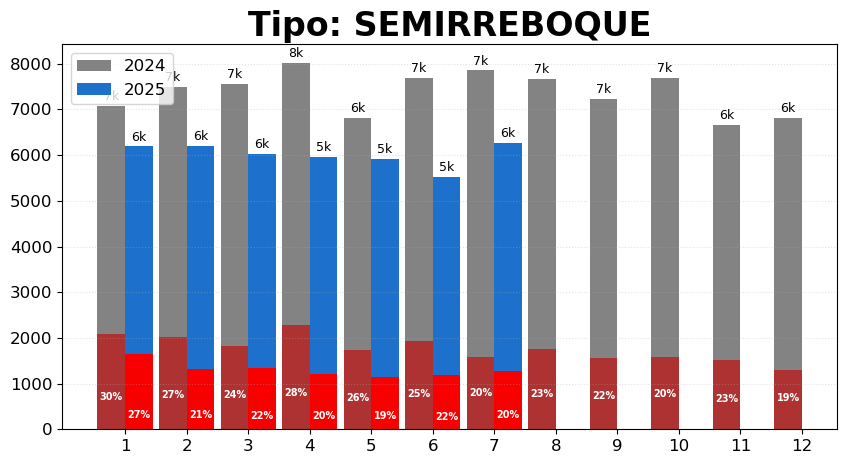

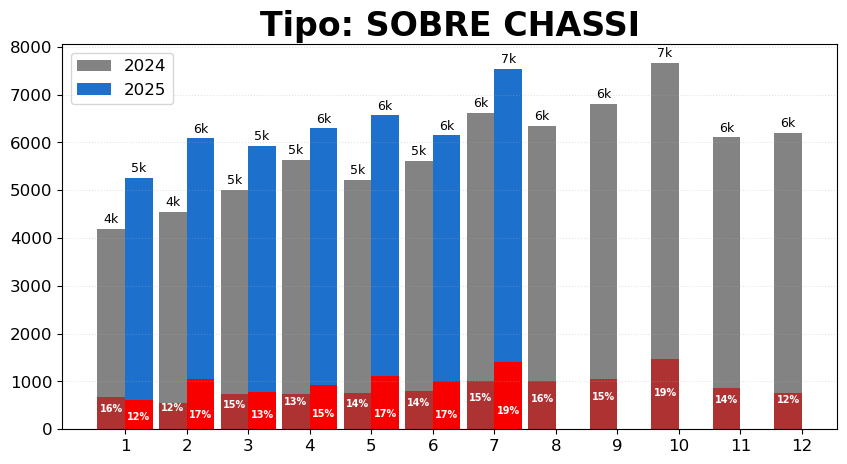

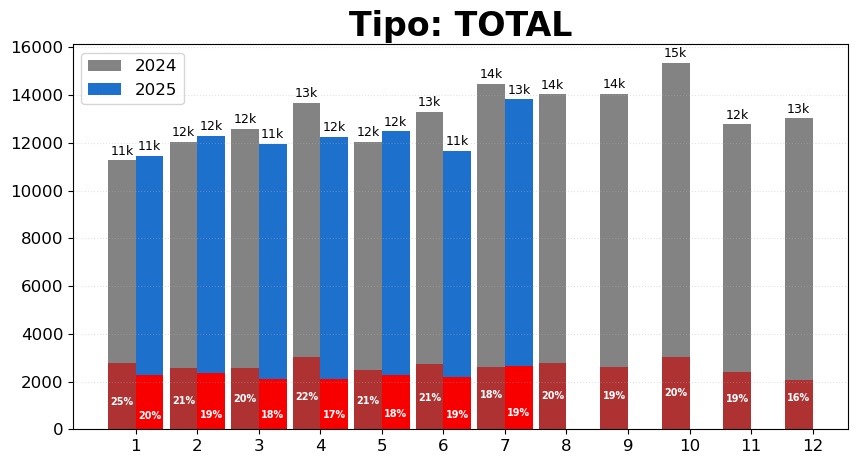

In [41]:
plot_segmentados(dados, facchini_dados, tipos, ano_prev, ano_max, mes_limite_atual)
plot_total(dados, facchini_dados, ano_prev, ano_max, mes_limite_atual)

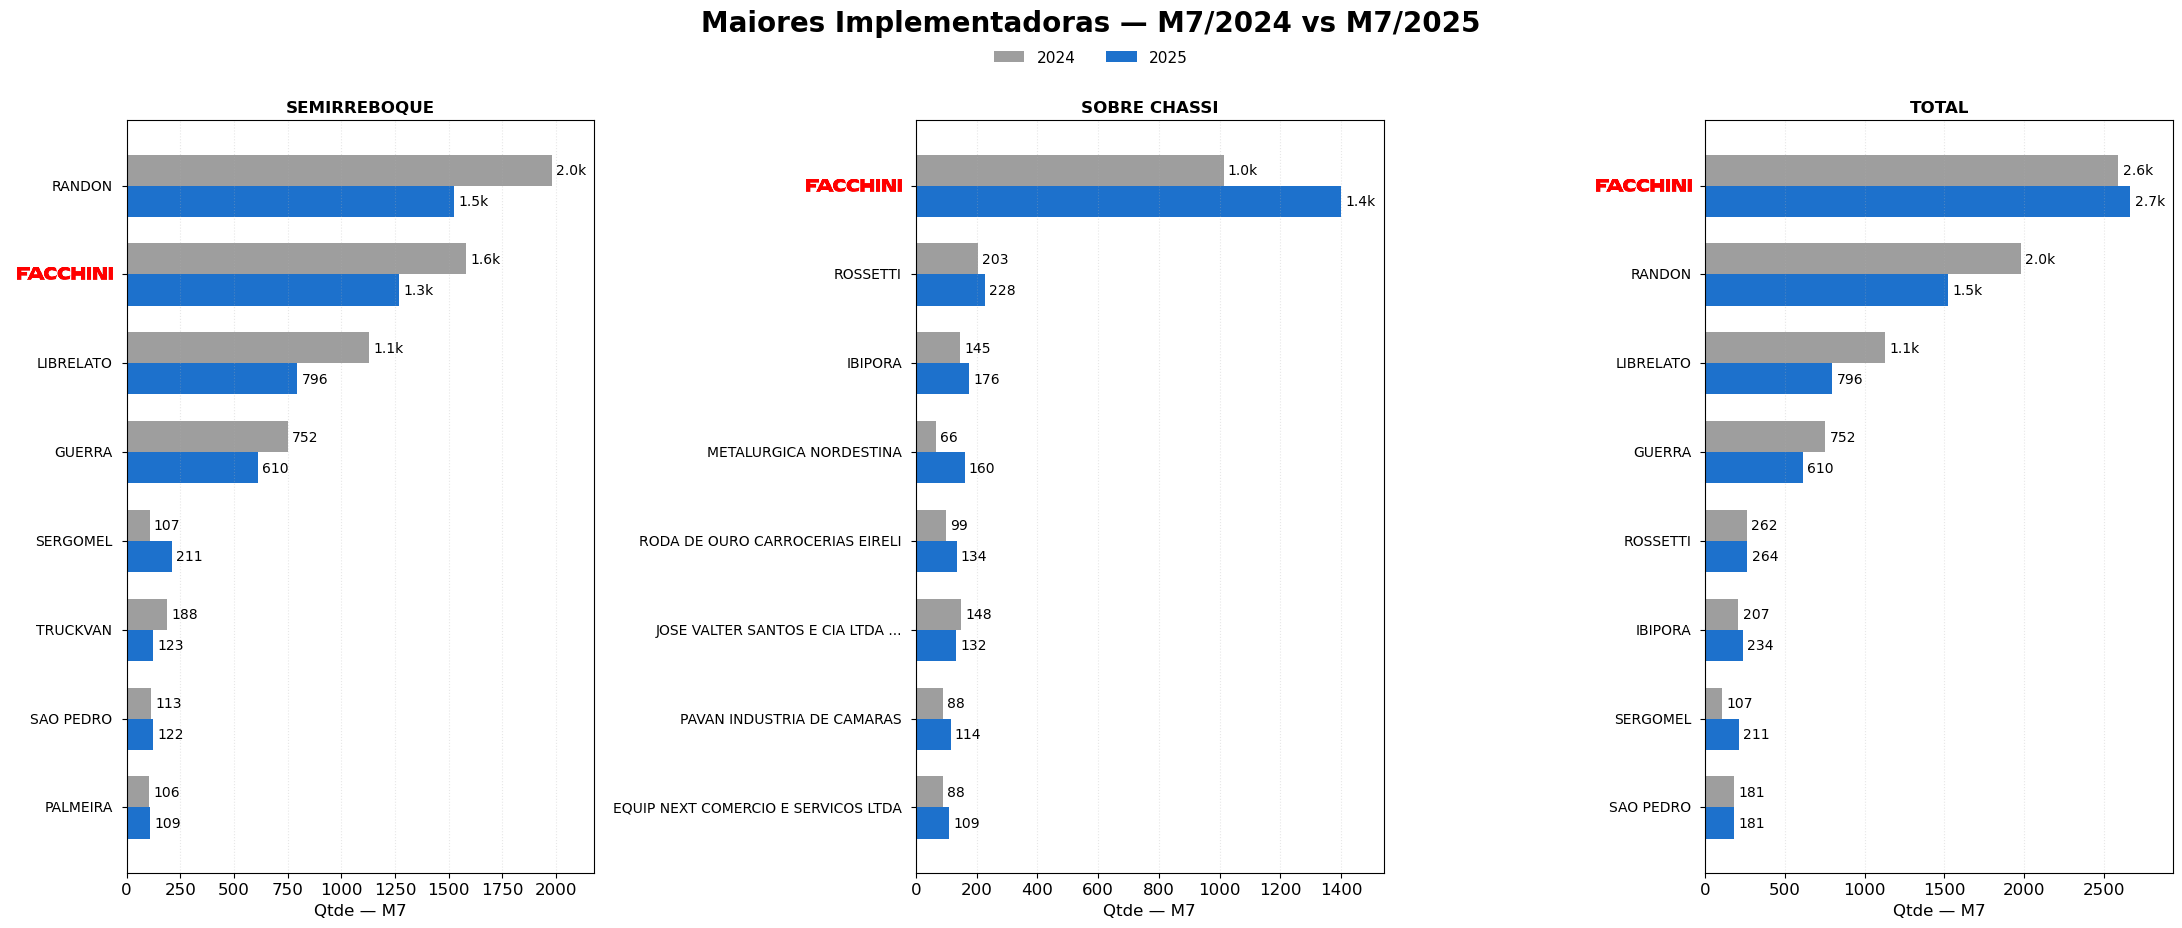

In [44]:
# Base
# ======================
df = df_emplacamento.copy()
df = df[(df['Ano'] >= 2024) & (~df['Tipo'].isna())]
df['Qtde'] = pd.to_numeric(df['Qtde'], errors='coerce').fillna(0)
df['Mes']  = pd.to_numeric(df['Mes'],  errors='coerce').astype('Int64')

# Define ano atual/prev e o mês atual (último mês disponível no ano atual)
ano_max  = int(df['Ano'].max())
ano_prev = ano_max - 1
mes_atual = int(df.loc[df['Ano'] == ano_max, 'Mes'].max())   # ex.: 7 para julho

# Filtra só os dois anos e o mês-alvo (mês atual de ambos os anos)
base_mes = df[(df['Ano'].isin([ano_prev, ano_max])) & (df['Mes'] == mes_atual)].copy()

# Agrega por Tipo + Implementadora
g_tipo = (base_mes
          .groupby(['Ano','Tipo','Implementadora'], as_index=False)['Qtde']
          .sum())

# Agrega TOTAL (sem Tipo)
g_total = (base_mes
           .groupby(['Ano','Implementadora'], as_index=False)['Qtde']
           .sum()
           .assign(Tipo='TOTAL'))[['Ano','Tipo','Implementadora','Qtde']]

# Combina
g = pd.concat([g_tipo, g_total], ignore_index=True)

# ======================
# Funções auxiliares
# ======================
def abrevia(v):  # 12345 -> 12.3k
    return f"{v/1000:.1f}k" if v >= 1000 else f"{v:.0f}"

# Tipos na ordem desejada (TOTAL por último)
tipos = [t for t in g['Tipo'].dropna().unique() if t != 'TOTAL']
tipos = sorted(tipos) + ['TOTAL']

top_n = 8  # quantas implementadoras mostrar por painel

# Paleta
cor_prev = "#9e9e9e"   # 2024
cor_atual = "#1d71cc"  # 2025

# ======================
# Carrega logo FACCHINI
# ======================
logo_facchini = plt.imread("arquivos/logoprincipal.png")   # <<< coloque o caminho certo
zoom_logo = 0.3  # ajuste o tamanho da logo

# ======================
# Plot
# ======================
fig, axes = plt.subplots(1, 3, figsize=(22, 9), sharex=False, sharey=False)
if not isinstance(axes, np.ndarray):  # caso raro de um painel só
    axes = np.array([axes])

handles_legend = []
labels_legend = []

for i, tipo in enumerate(tipos[:3]):  # 2 tipos + TOTAL
    ax = axes[i]

    # prepara tabela pivot (linhas = Implementadora; cols = [ano_prev, ano_max])
    tab = (g[g['Tipo'] == tipo]
           .pivot_table(index='Implementadora', columns='Ano', values='Qtde',
                        aggfunc='sum', fill_value=0)
           .reindex(columns=[ano_prev, ano_max], fill_value=0))

    # ordena pelo ano atual e pega Top N
    tab = tab.sort_values(by=ano_max, ascending=False).head(top_n)

    y = np.arange(len(tab))
    h = 0.35

    # barras horizontais
    b_prev = ax.barh(y - h/2, tab[ano_prev].to_numpy(), height=h, color=cor_prev, label=str(ano_prev))
    b_atua = ax.barh(y + h/2, tab[ano_max ].to_numpy(), height=h, color=cor_atual, label=str(ano_max))

    # calcula o maior valor do gráfico
    max_val = float(tab[[ano_prev, ano_max]].to_numpy().max())
    ax.set_xlim(0, max_val * 1.10)   # garante 15% de folga à direita
    pad = max_val * 0.01             # deslocamento de 1% do eixo

    # rótulos nas pontas das barras
    for rect, val in zip(b_atua, tab[ano_max].to_numpy()):
        ax.text(rect.get_width() + pad,
                rect.get_y() + rect.get_height()/2,
                abrevia(val), va='center', fontsize=10)
    for rect, val in zip(b_prev, tab[ano_prev].to_numpy()):
        ax.text(rect.get_width() + pad,
                rect.get_y() + rect.get_height()/2,
                abrevia(val), va='center', fontsize=10)

    # eixo y com nomes das implementadoras (texto ou logo FACCHINI)
    ax.set_yticks(y)
    ax.set_yticklabels([""] * len(tab))  # vamos desenhar manualmente
    ax.invert_yaxis()  # topo = maior

    xpad_frac = -0.03   # deslocamento horizontal em fração do eixo
    for yi, impl in zip(y, tab.index.tolist()):
        if str(impl).strip().upper() == "FACCHINI":
            img = OffsetImage(logo_facchini, zoom=zoom_logo)
            ab = AnnotationBbox(
                img,
                (xpad_frac, yi),
                xycoords=('axes fraction','data'),  # x em fração do eixo, y em dados
                frameon=False,
                box_alignment=(1, 0.5)
            )
            ab.set_clip_on(False)
            ax.add_artist(ab)
        else:
            ax.text(
                xpad_frac, yi, impl,
                transform=ax.get_yaxis_transform(),
                ha='right', va='center', fontsize=10, clip_on=False
            )

    # título e estética
    ax.set_title(f"{tipo}", fontsize=12, fontweight='bold')
    ax.grid(axis='x', linestyle=':', alpha=0.3)
    ax.set_xlabel(f"Qtde — M{mes_atual}")

    if i == 0:
        handles_legend = [b_prev, b_atua]
        labels_legend  = [str(ano_prev), str(ano_max)]

fig.legend(handles_legend, labels_legend,
           loc='upper center', ncol=2, frameon=False, fontsize=11,
           bbox_to_anchor=(0.5, 1))  # legenda no topo

fig.suptitle(f"Maiores Implementadoras — M{mes_atual}/{ano_prev} vs M{mes_atual}/{ano_max}",
             fontsize=20, fontweight='bold', y=1.03)  # título mais alto

plt.tight_layout()
plt.show()

In [2]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
